# Q1: Multi-Task CNN on Fashion-MNIST

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score 
from sklearn.model_selection import StratifiedShuffleSplit
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# =========================
# Watermark Function
# =========================
def add_watermark(ax=None, username="anuga.indu"):
    """
    Adds a watermark to the current axes or specified axes.
    
    Args:
        ax: matplotlib axes object (if None, uses current axes)
        username: email username to display
    """
    if ax is None:
        ax = plt.gca()
    
    ax.text(
        0.95, 0.95, username,
        ha='right', va='top',
        transform=ax.transAxes,
        fontsize=10, color='gray', alpha=0.7
    )

##  Data Loading and Preprocessing

In [3]:
# # Load the Fashion MNIST training dataset
# # Ensure you have the 'data' directory for storing the downloaded dataset
# train_dataset_td = datasets.FashionMNIST(root='./data', train=True, download=True)

# # Convert the dataset to a PyTorch tensor and calculate mean and std
# # The pixel values are typically in the range [0, 255]
# # We need to convert them to float and scale to [0, 1] for normalization
# data_d = train_dataset_td.data.float() / 255.0

# # Calculate the mean and standard deviation
# mean_m = data_d.mean()
# std_sd = data_d.std()

# print(f"Fashion MNIST Mean: {mean_m.item()}")
# print(f"Fashion MNIST Standard Deviation: {std_sd.item()}")

In [4]:
# =========================
# Custom Dataset Class
# =========================
class FashionMNISTDataset(Dataset):
    """
    Multi-task Fashion-MNIST Dataset:
    Returns (image, class_label, ink_target)
    Handles augmentations and ink computation internally.
    """
    def __init__(self, dataset, train=True):
        self.dataset = dataset
        self.train = train
        self.mean = 0.2860
        self.std = 0.3530
        
        # Transforms
        self.train_transform = transforms.Compose([
            transforms.RandomCrop(28, padding=2),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((self.mean,), (self.std,))
        ])
        self.test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((self.mean,), (self.std,))
        ])
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        
        # Apply transforms
        if self.train:
            image = self.train_transform(image)
        else:
            image = self.test_transform(image)
        
        # Compute ink target (average pixel intensity before normalization)
        image_unnorm = image * self.std + self.mean
        ink_target = image_unnorm.mean()
        
        return image, label, ink_target


# ====================================
# Stratified Train/Validation Split
# ====================================
def stratified_split(dataset, val_ratio=0.1, random_state=42):
    labels = np.array([dataset[i][1] for i in range(len(dataset))])
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=random_state)
    train_idx, val_idx = next(splitter.split(np.zeros(len(labels)), labels))
    return train_idx, val_idx


# =========================
# Load Data Function
# =========================
def load_fashion_data(batch_size=64, val_ratio=0.1, download=True):
    """
    Loads Fashion-MNIST, splits train/val with stratification,
    wraps datasets in custom multi-task dataset, and returns DataLoaders.
    """
    # Load raw datasets
    full_train = datasets.FashionMNIST(root='./data', train=True, download=download)
    test_dataset_raw = datasets.FashionMNIST(root='./data', train=False, download=download)
    
    # Stratified split for train/validation
    train_idx, val_idx = stratified_split(full_train, val_ratio=val_ratio)
    
    # Create Subsets
    train_subset = Subset(full_train, train_idx)
    val_subset = Subset(full_train, val_idx)
    
    # Wrap subsets in custom dataset
    train_dataset = FashionMNISTDataset(train_subset, train=True)
    val_dataset = FashionMNISTDataset(val_subset, train=False)
    test_dataset = FashionMNISTDataset(test_dataset_raw, train=False)
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = load_fashion_data(batch_size=64)

# Test one batch
for images, labels, ink in train_loader:
    print("Images:", images.shape)      # [batch_size, 1, 28, 28]
    print("Labels:", labels.shape)      # [batch_size]
    print("Ink targets:", ink.shape)    # [batch_size]
    break

100%|██████████| 26.4M/26.4M [02:38<00:00, 166kB/s] 


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 183kB/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:06<00:00, 694kB/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw

Images: torch.Size([64, 1, 28, 28])
Labels: torch.Size([64])
Ink targets: torch.Size([64])


## Model Implementation: Multi-Task CNN

In [5]:
# =========================
# Multi-Task CNN Model 
# =========================
class MultiTaskCNN(nn.Module):
    def __init__(self, num_blocks=3, filters=[32, 64, 128], dropout_prob=0.3):
        """
        Args:
            num_blocks: Number of convolutional blocks
            filters: List of filter sizes for each block (length should match num_blocks)
            dropout_prob: Dropout probability
        """
        super(MultiTaskCNN, self).__init__()
        
        assert len(filters) == num_blocks, "Length of filters must match num_blocks"
        
        # Dynamically build convolutional backbone
        layers = []
        in_channels = 1  # Grayscale input
        
        for i in range(num_blocks):
            out_channels = filters[i]
            layers.extend([
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Dropout(dropout_prob)
            ])
            in_channels = out_channels
        
        self.backbone = nn.Sequential(*layers)
        
        # Calculate output size after conv blocks
        # Starting size: 28x28, after each MaxPool2d(2): size // 2
        final_size = 28 // (2 ** num_blocks)
        flattened_size = filters[-1] * final_size * final_size
        
        self.flatten = nn.Flatten()
        self.fc_shared = nn.Linear(flattened_size, 256)  # Shared fully connected layer
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(128, 10)   # 10 classes
        )
        
        # Regression head
        self.regressor = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(128, 1)   # Scalar output
        )
        
    def forward(self, x, return_features=False):
        features = self.backbone(x)  # Shared conv backbone
        features_flat = self.flatten(features)
        shared = self.fc_shared(features_flat)
        
        class_out = self.classifier(shared)  # [B, 10]
        reg_out = self.regressor(shared)     # [B, 1]
        
        if return_features:
            return class_out, reg_out, features
        return class_out, reg_out
    
        
# =========================
# Joint Loss Function
# =========================
def multi_task_loss(class_logits, class_labels, reg_preds, reg_targets, lambda_class=1.0, lambda_reg=1.0):
    """
    Computes joint loss: Ltotal = λ1 * CrossEntropy + λ2 * MSE
    """
    ce_loss = F.cross_entropy(class_logits, class_labels)
    mse_loss = F.mse_loss(reg_preds.squeeze(1), reg_targets)
    total_loss = lambda_class * ce_loss + lambda_reg * mse_loss
    return total_loss, ce_loss, mse_loss
    


# model = MultiTaskCNN()
# model.train()

# # Dummy batch
# images = torch.randn(8, 1, 28, 28)
# labels = torch.randint(0, 10, (8,))
# ink = torch.rand(8)

# # Forward pass
# class_logits, reg_preds = model(images)
# print("Class logits:", class_logits.shape)  # [8, 10]
# print("Regression preds:", reg_preds.shape) # [8, 1]

# # Compute joint loss
# total_loss, ce_loss, mse_loss = multi_task_loss(class_logits, labels, reg_preds, ink, lambda_class=1.0, lambda_reg=1.0)
# print(f"Total Loss: {total_loss.item():.4f}, CE Loss: {ce_loss.item():.4f}, MSE Loss: {mse_loss.item():.4f}")

## Hyperparameter Tuning, WandB Logging and Feature Map Visualization

wandb: Currently logged in as: anugaindu17 (anugaindu17-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/10 | Train Loss: 0.7629 | Val Acc: 0.8138 | Val RMSE: 0.0415
Epoch 2/10 | Train Loss: 0.5449 | Val Acc: 0.8467 | Val RMSE: 0.0243
Epoch 3/10 | Train Loss: 0.4885 | Val Acc: 0.8715 | Val RMSE: 0.0315
Epoch 4/10 | Train Loss: 0.4558 | Val Acc: 0.8687 | Val RMSE: 0.0279
Epoch 5/10 | Train Loss: 0.4356 | Val Acc: 0.8807 | Val RMSE: 0.0342
Epoch 6/10 | Train Loss: 0.4214 | Val Acc: 0.8865 | Val RMSE: 0.0256
Epoch 7/10 | Train Loss: 0.4089 | Val Acc: 0.8827 | Val RMSE: 0.0269
Epoch 8/10 | Train Loss: 0.4015 | Val Acc: 0.8905 | Val RMSE: 0.0267
Epoch 9/10 | Train Loss: 0.3924 | Val Acc: 0.8958 | Val RMSE: 0.0253
Epoch 10/10 | Train Loss: 0.3803 | Val Acc: 0.9017 | Val RMSE: 0.0311


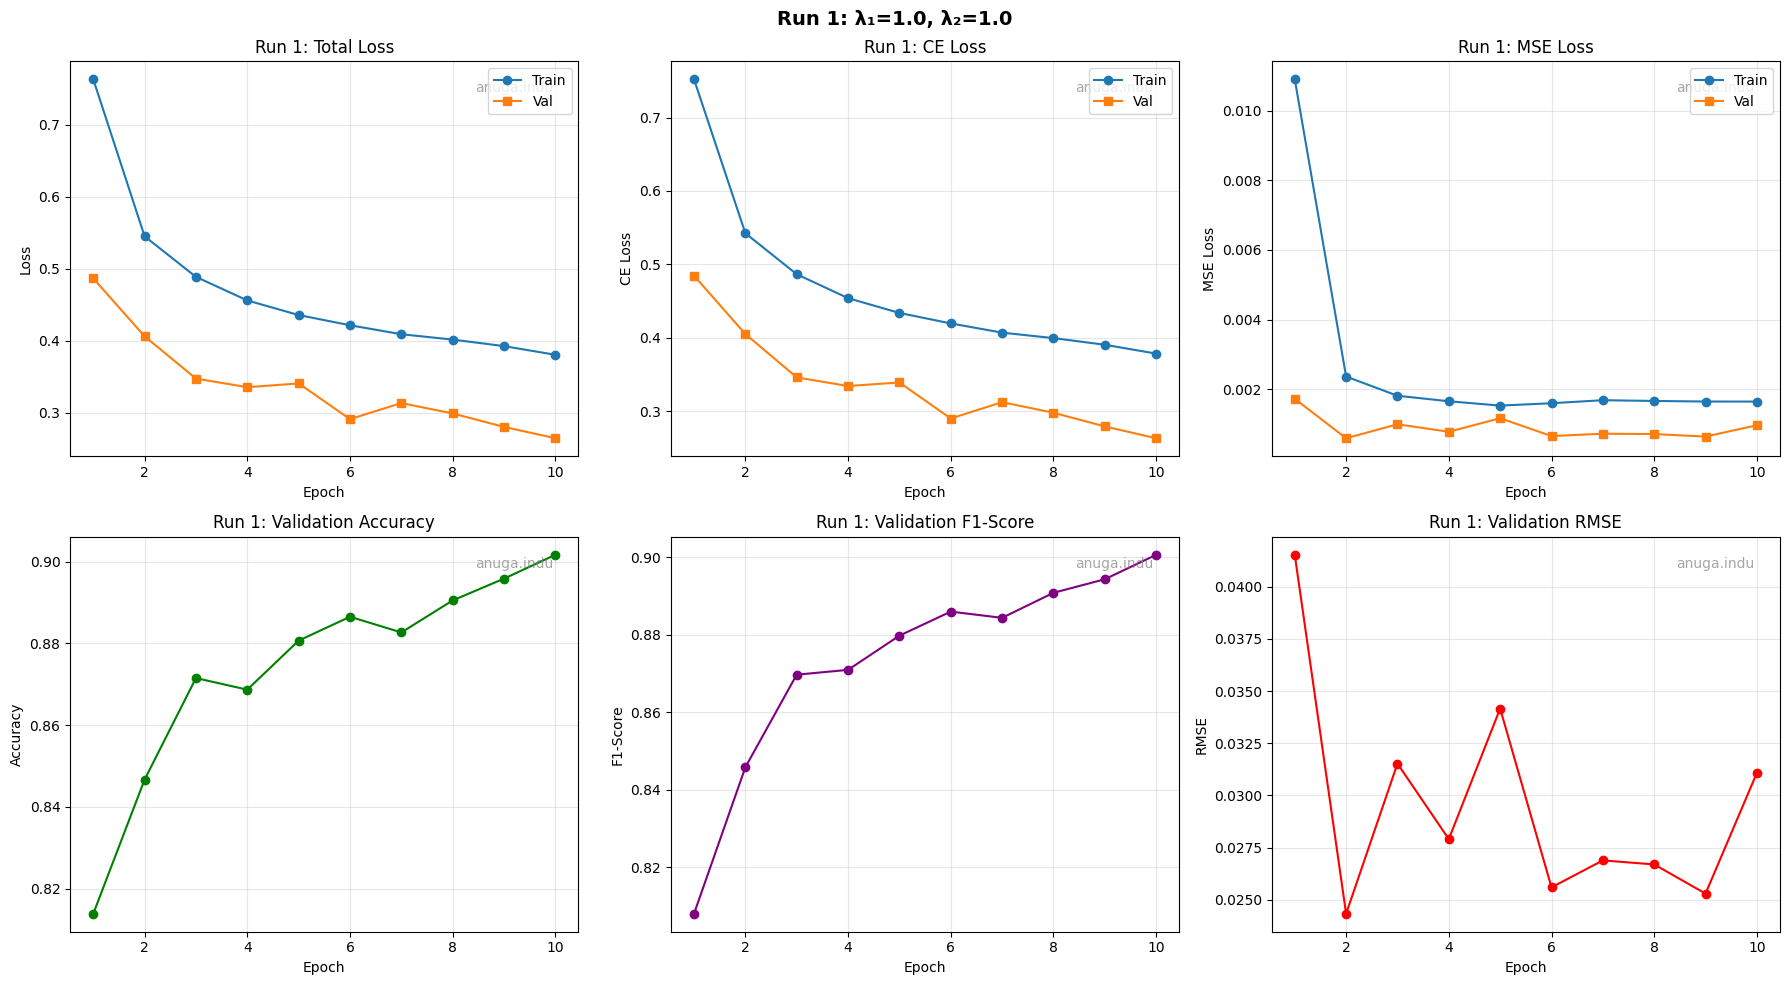

Run 1 Test | Acc: 0.8931 | MAE: 0.0235 | RMSE: 0.0311

FEATURE MAPS FOR RUN 1

Run 1 - Test Image 1
True: Ankle boot | Pred: Ankle boot
True Ink: 0.1673 | Pred Ink: 0.2021


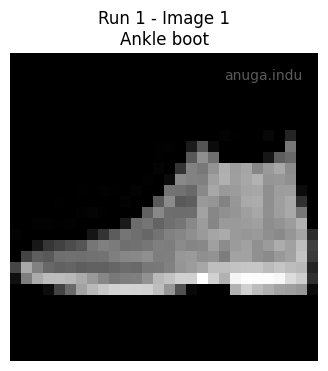

  Conv_0 - Shape: torch.Size([1, 32, 28, 28])


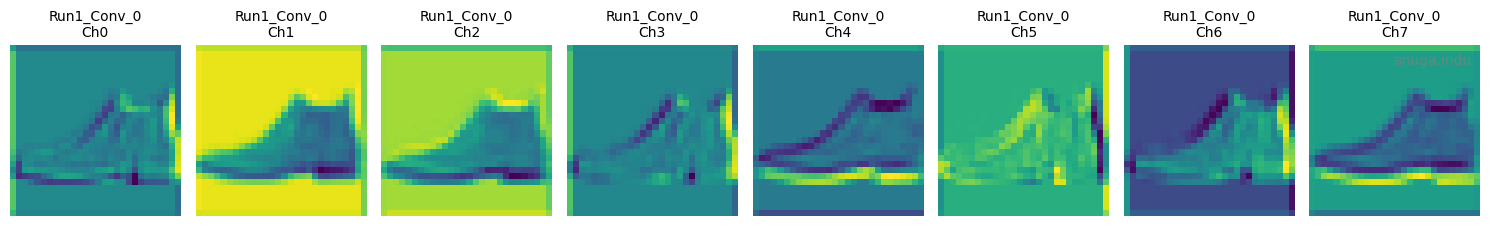

  Conv_1 - Shape: torch.Size([1, 64, 14, 14])


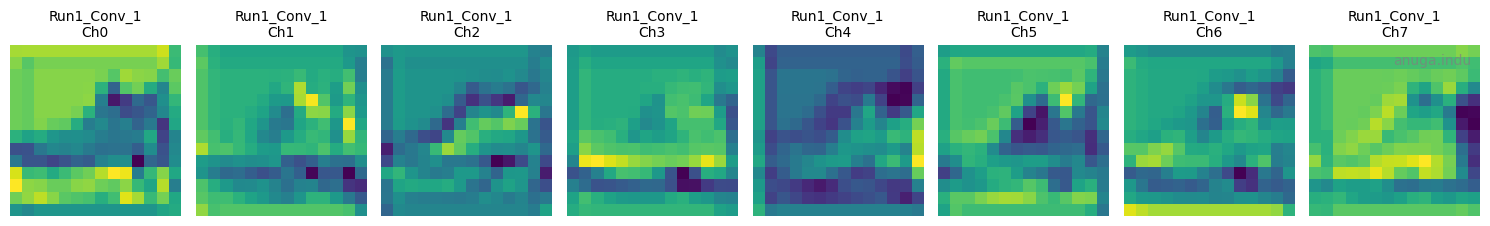

  Conv_2 - Shape: torch.Size([1, 128, 7, 7])


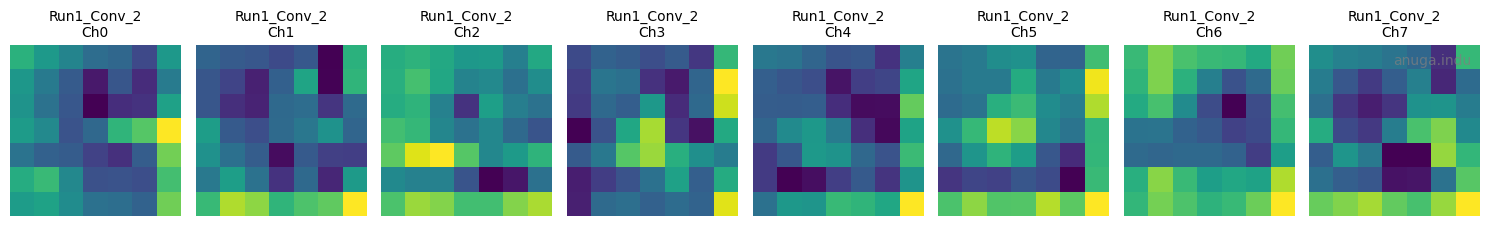


Run 1 - Test Image 2
True: Pullover | Pred: Pullover
True Ink: 0.5052 | Pred Ink: 0.4077


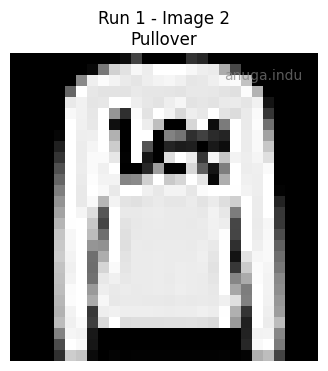

  Conv_0 - Shape: torch.Size([1, 32, 28, 28])


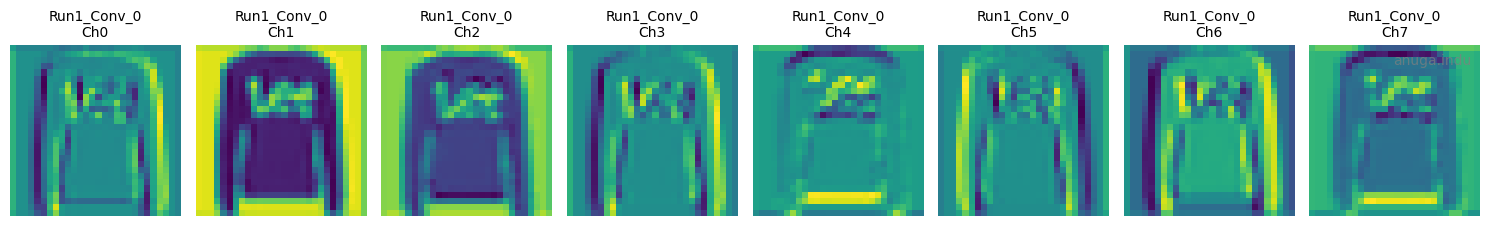

  Conv_1 - Shape: torch.Size([1, 64, 14, 14])


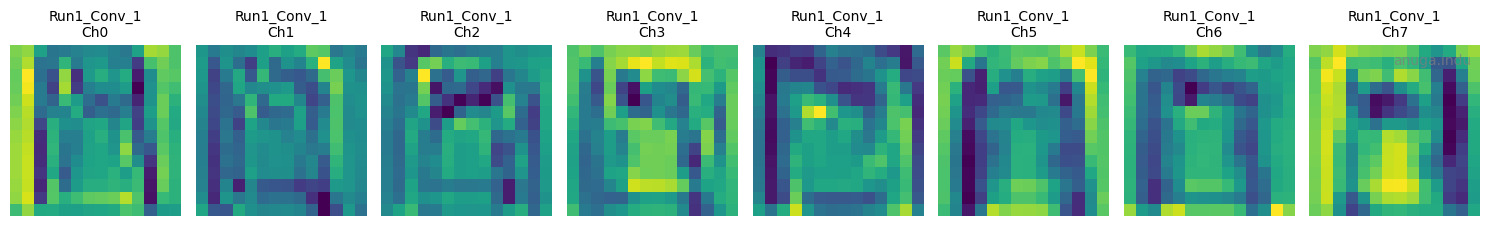

  Conv_2 - Shape: torch.Size([1, 128, 7, 7])


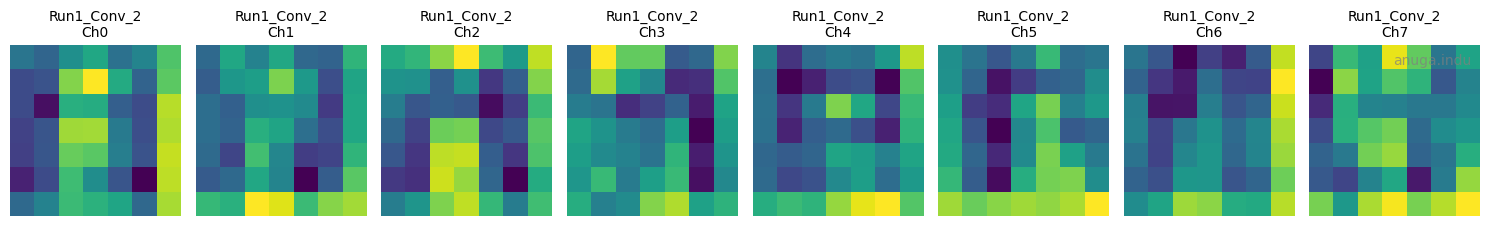


Run 1 - Test Image 3
True: Trouser | Pred: Trouser
True Ink: 0.2577 | Pred Ink: 0.2370


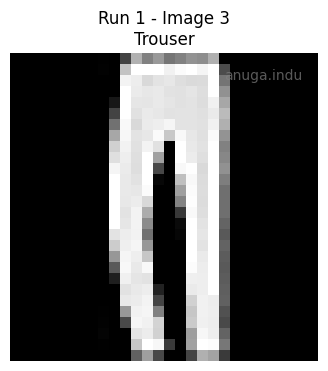

  Conv_0 - Shape: torch.Size([1, 32, 28, 28])


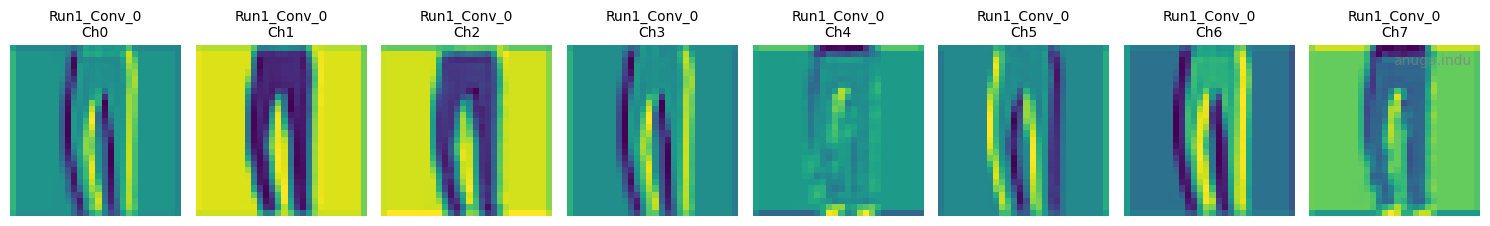

  Conv_1 - Shape: torch.Size([1, 64, 14, 14])


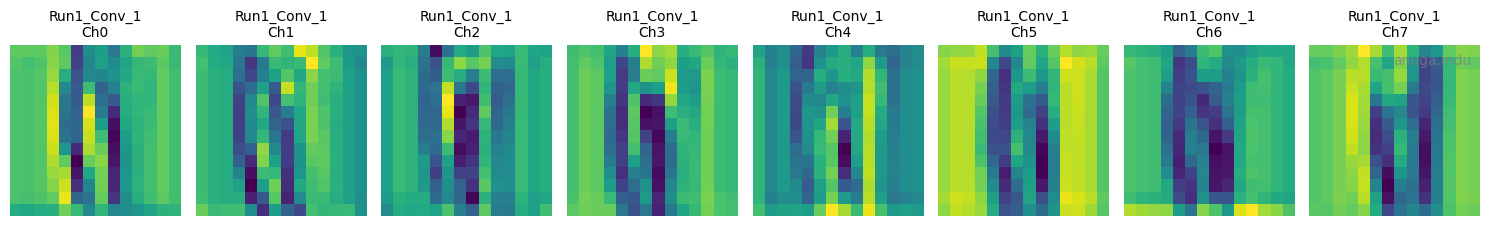

  Conv_2 - Shape: torch.Size([1, 128, 7, 7])


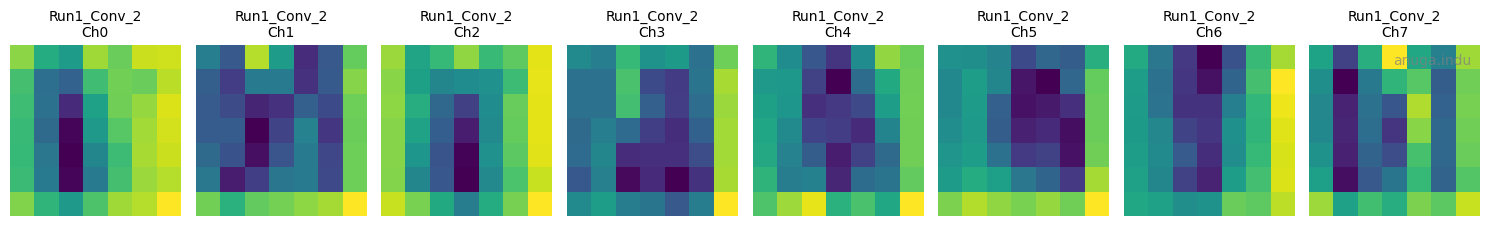

epoch,▁▂▃▃▄▅▆▆▇█
test/accuracy,▁
test/mae,▁
test/rmse,▁
train/ce_loss,█▄▃▂▂▂▂▁▁▁
train/loss,█▄▃▂▂▂▂▁▁▁
train/mse_loss,█▂▁▁▁▁▁▁▁▁
val/accuracy,▁▄▆▅▆▇▆▇██
val/ce_loss,█▅▄▃▃▂▃▂▂▁
val/f1_score,▁▄▆▆▆▇▇▇██
+4,...


Epoch 1/10 | Train Loss: 1.7756 | Val Acc: 0.7865 | Val RMSE: 0.0522
Epoch 2/10 | Train Loss: 1.3810 | Val Acc: 0.8007 | Val RMSE: 0.0616
Epoch 3/10 | Train Loss: 1.2772 | Val Acc: 0.8268 | Val RMSE: 0.0373
Epoch 4/10 | Train Loss: 1.2022 | Val Acc: 0.8467 | Val RMSE: 0.0408
Epoch 5/10 | Train Loss: 1.1484 | Val Acc: 0.8488 | Val RMSE: 0.0422
Epoch 6/10 | Train Loss: 1.1147 | Val Acc: 0.8498 | Val RMSE: 0.0371
Epoch 7/10 | Train Loss: 1.0845 | Val Acc: 0.8445 | Val RMSE: 0.0319
Epoch 8/10 | Train Loss: 1.0510 | Val Acc: 0.8602 | Val RMSE: 0.0352
Epoch 9/10 | Train Loss: 1.0349 | Val Acc: 0.8628 | Val RMSE: 0.0397
Epoch 10/10 | Train Loss: 1.0127 | Val Acc: 0.8758 | Val RMSE: 0.0467


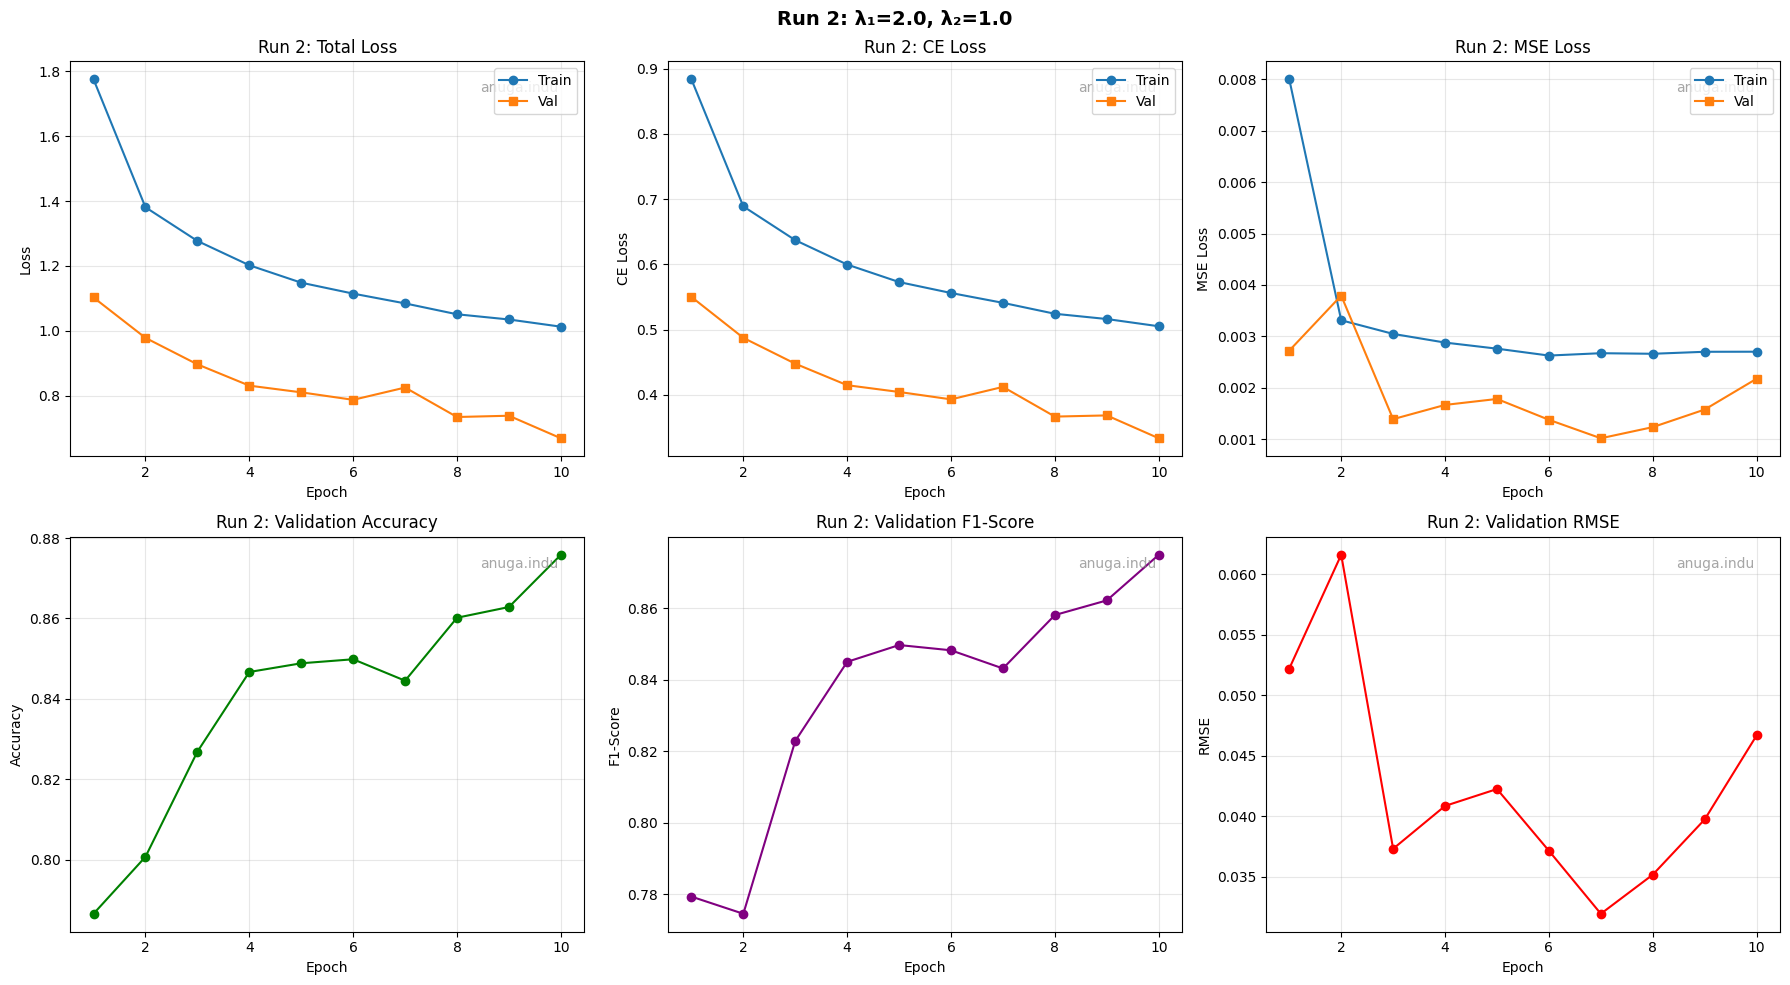

Run 2 Test | Acc: 0.8624 | MAE: 0.0364 | RMSE: 0.0471

FEATURE MAPS FOR RUN 2

Run 2 - Test Image 1
True: Ankle boot | Pred: Ankle boot
True Ink: 0.1673 | Pred Ink: 0.1832


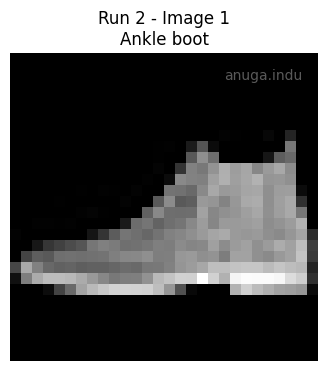

  Conv_0 - Shape: torch.Size([1, 32, 28, 28])


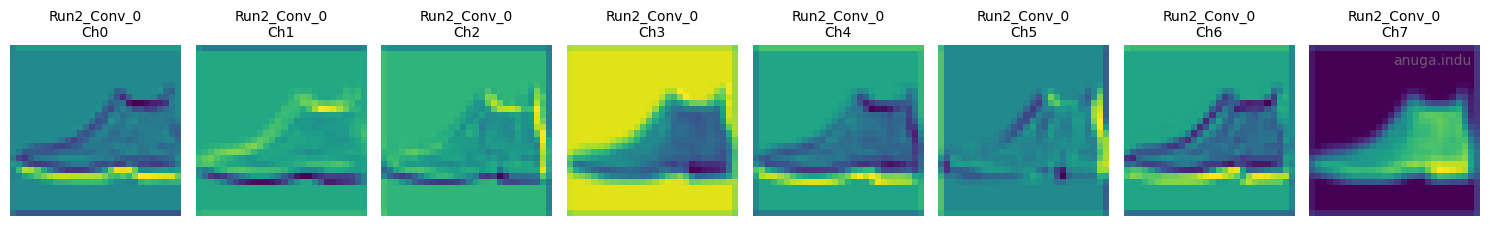

  Conv_1 - Shape: torch.Size([1, 64, 14, 14])


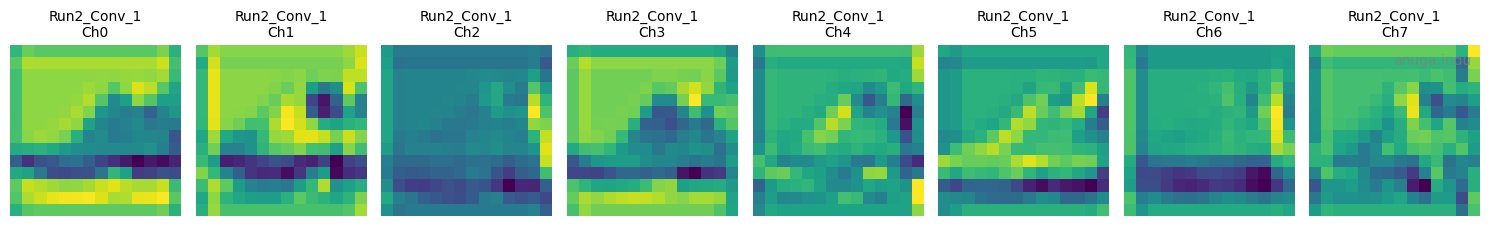

  Conv_2 - Shape: torch.Size([1, 128, 7, 7])


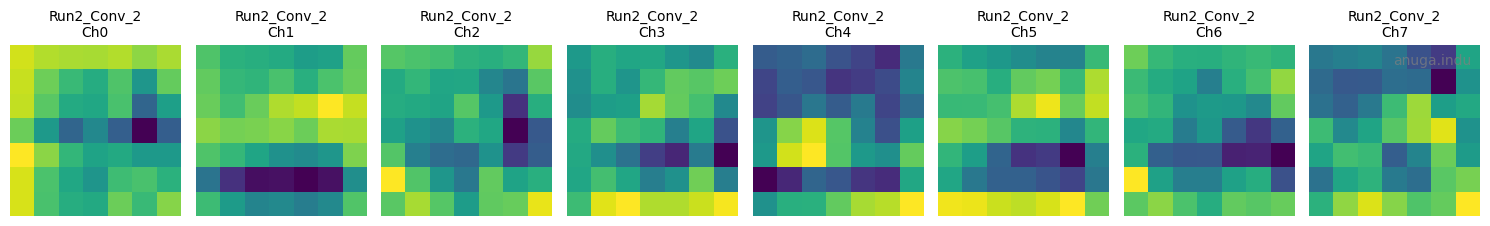


Run 2 - Test Image 2
True: Pullover | Pred: Pullover
True Ink: 0.5052 | Pred Ink: 0.3883


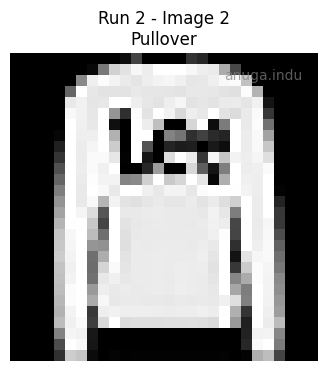

  Conv_0 - Shape: torch.Size([1, 32, 28, 28])


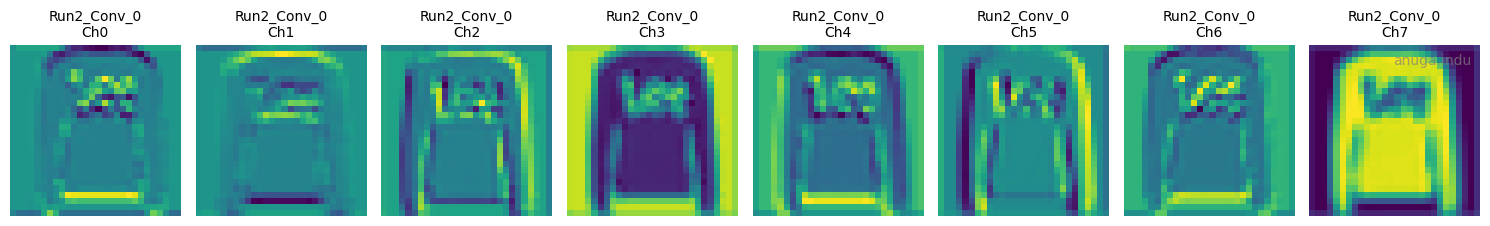

  Conv_1 - Shape: torch.Size([1, 64, 14, 14])


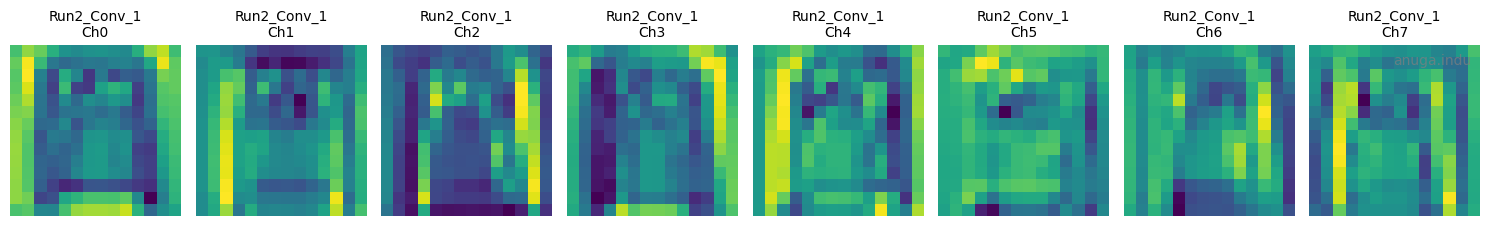

  Conv_2 - Shape: torch.Size([1, 128, 7, 7])


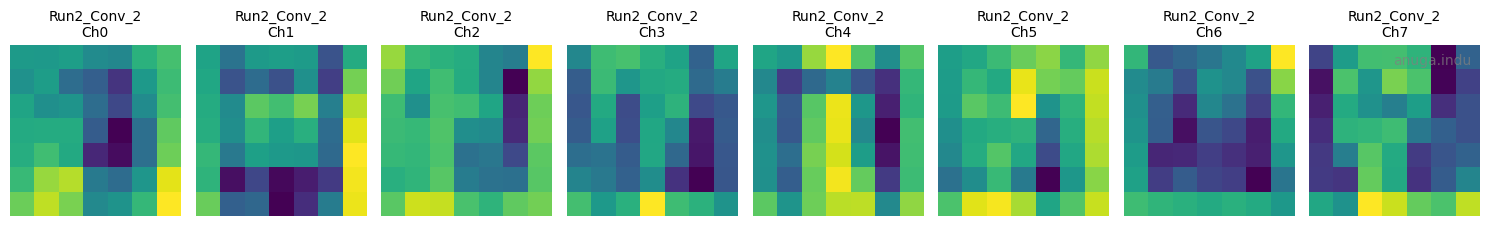


Run 2 - Test Image 3
True: Trouser | Pred: Trouser
True Ink: 0.2577 | Pred Ink: 0.2392


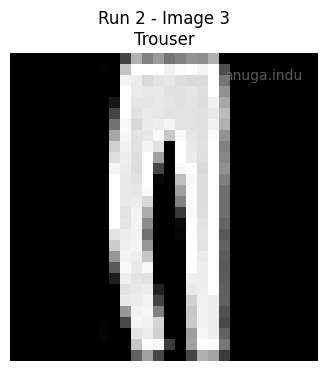

  Conv_0 - Shape: torch.Size([1, 32, 28, 28])


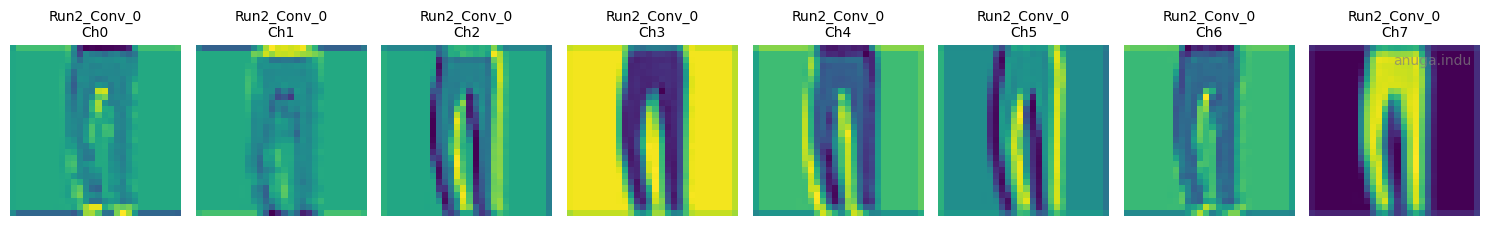

  Conv_1 - Shape: torch.Size([1, 64, 14, 14])


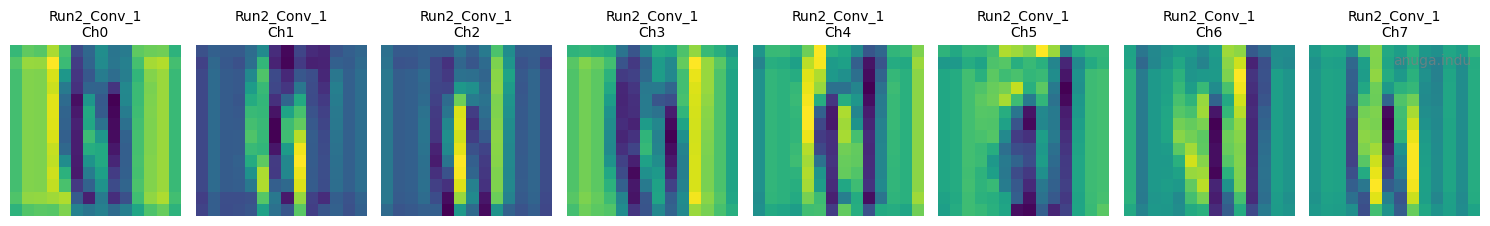

  Conv_2 - Shape: torch.Size([1, 128, 7, 7])


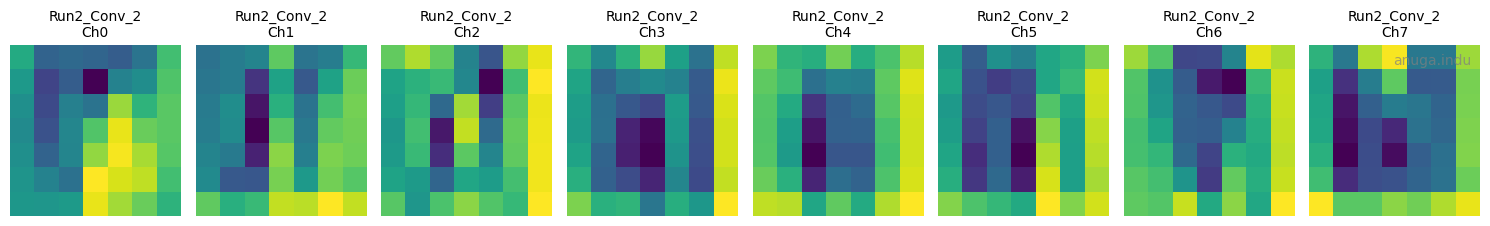

epoch,▁▂▃▃▄▅▆▆▇█
test/accuracy,▁
test/mae,▁
test/rmse,▁
train/ce_loss,█▄▃▃▂▂▂▁▁▁
train/loss,█▄▃▃▂▂▂▁▁▁
train/mse_loss,█▂▂▁▁▁▁▁▁▁
val/accuracy,▁▂▄▆▆▆▆▇▇█
val/ce_loss,█▆▅▄▃▃▄▂▂▁
val/f1_score,▁▁▄▆▆▆▆▇▇█
+4,...


Epoch 1/10 | Train Loss: 0.9150 | Val Acc: 0.8022 | Val RMSE: 0.0411
Epoch 2/10 | Train Loss: 0.5861 | Val Acc: 0.8447 | Val RMSE: 0.0411
Epoch 3/10 | Train Loss: 0.5295 | Val Acc: 0.8632 | Val RMSE: 0.0403
Epoch 4/10 | Train Loss: 0.4937 | Val Acc: 0.8740 | Val RMSE: 0.0278
Epoch 5/10 | Train Loss: 0.4692 | Val Acc: 0.8713 | Val RMSE: 0.0245
Epoch 6/10 | Train Loss: 0.4543 | Val Acc: 0.8865 | Val RMSE: 0.0229
Epoch 7/10 | Train Loss: 0.4384 | Val Acc: 0.8833 | Val RMSE: 0.0232
Epoch 8/10 | Train Loss: 0.4277 | Val Acc: 0.8852 | Val RMSE: 0.0214
Epoch 9/10 | Train Loss: 0.4147 | Val Acc: 0.8922 | Val RMSE: 0.0198
Epoch 10/10 | Train Loss: 0.4057 | Val Acc: 0.8940 | Val RMSE: 0.0199


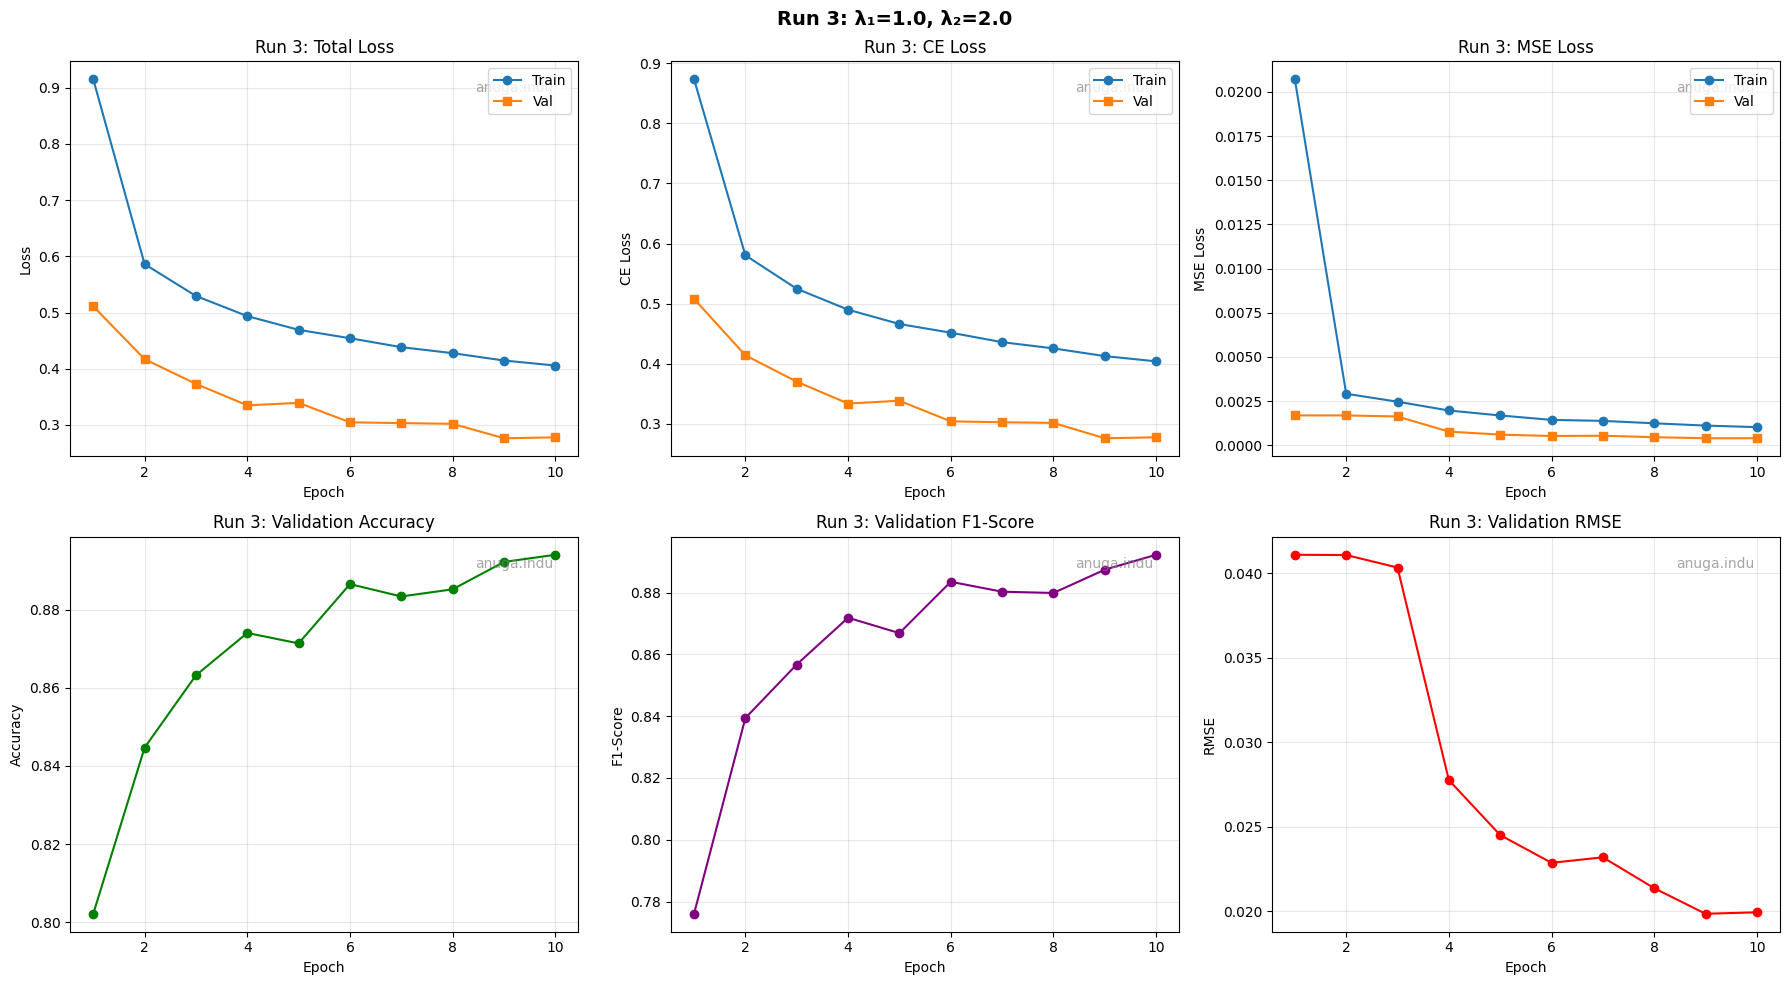

Run 3 Test | Acc: 0.8845 | MAE: 0.0159 | RMSE: 0.0201

FEATURE MAPS FOR RUN 3

Run 3 - Test Image 1
True: Ankle boot | Pred: Ankle boot
True Ink: 0.1673 | Pred Ink: 0.1790


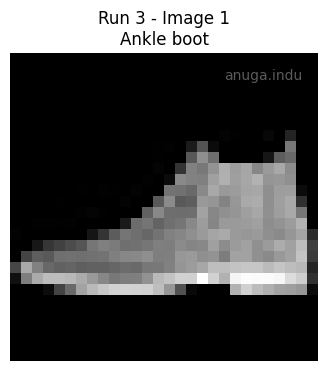

  Conv_0 - Shape: torch.Size([1, 32, 28, 28])


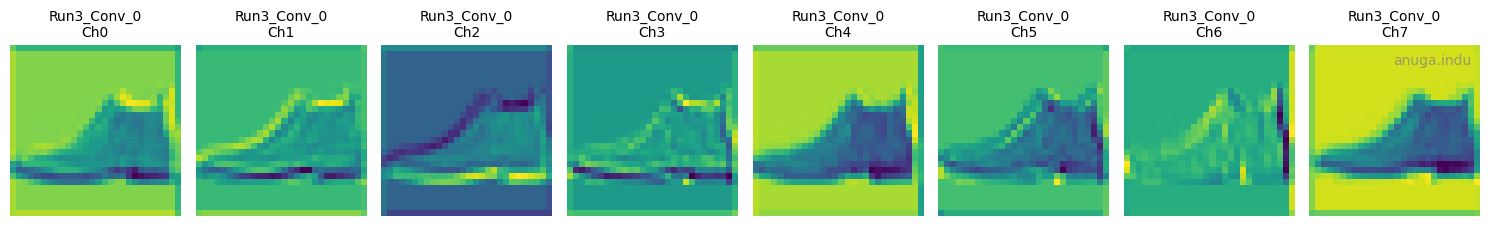

  Conv_1 - Shape: torch.Size([1, 64, 14, 14])


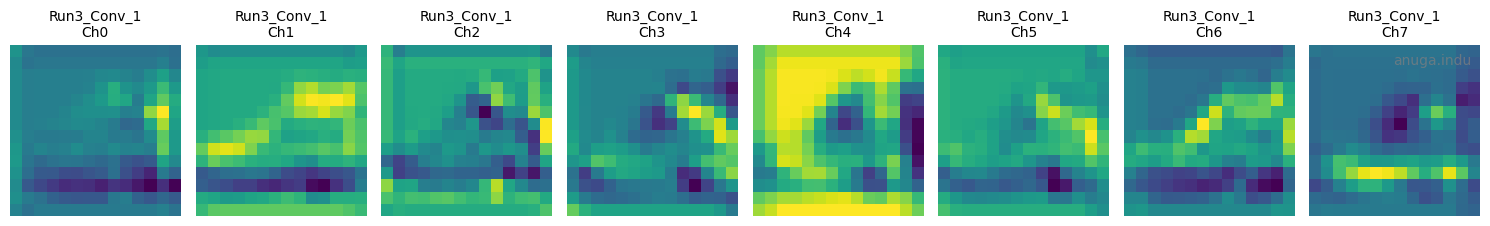


Run 3 - Test Image 2
True: Pullover | Pred: Pullover
True Ink: 0.5052 | Pred Ink: 0.4507


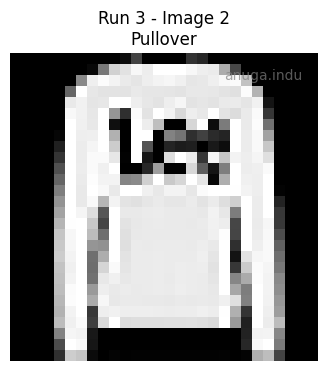

  Conv_0 - Shape: torch.Size([1, 32, 28, 28])


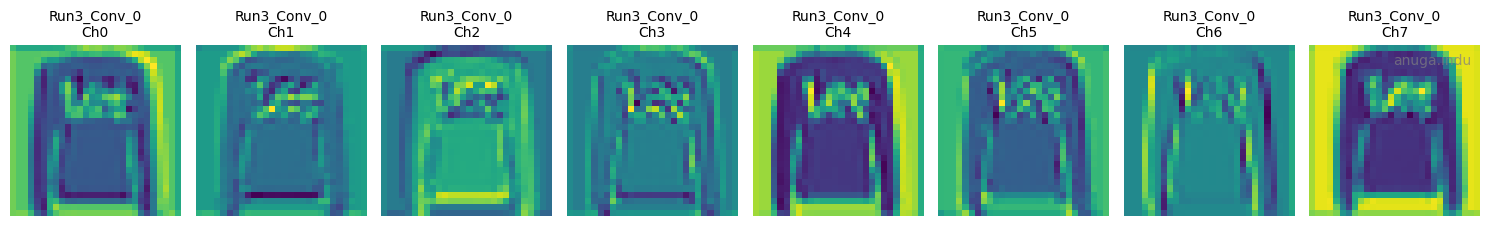

  Conv_1 - Shape: torch.Size([1, 64, 14, 14])


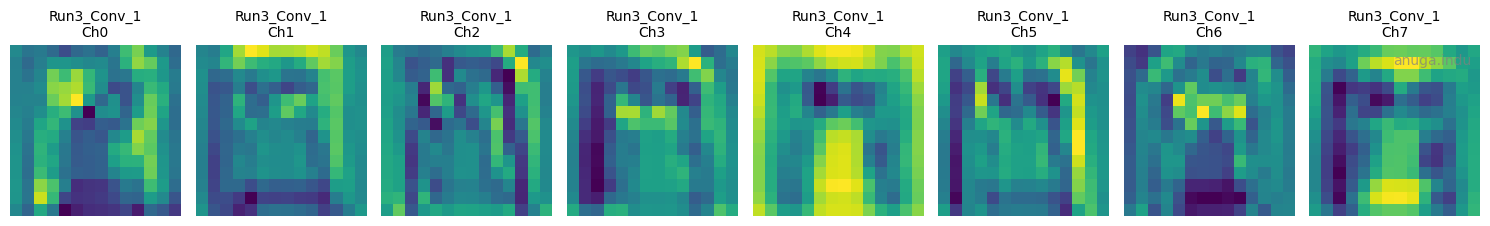


Run 3 - Test Image 3
True: Trouser | Pred: Trouser
True Ink: 0.2577 | Pred Ink: 0.2472


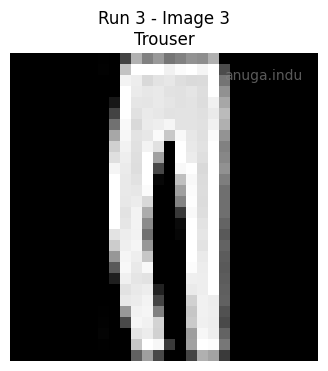

  Conv_0 - Shape: torch.Size([1, 32, 28, 28])


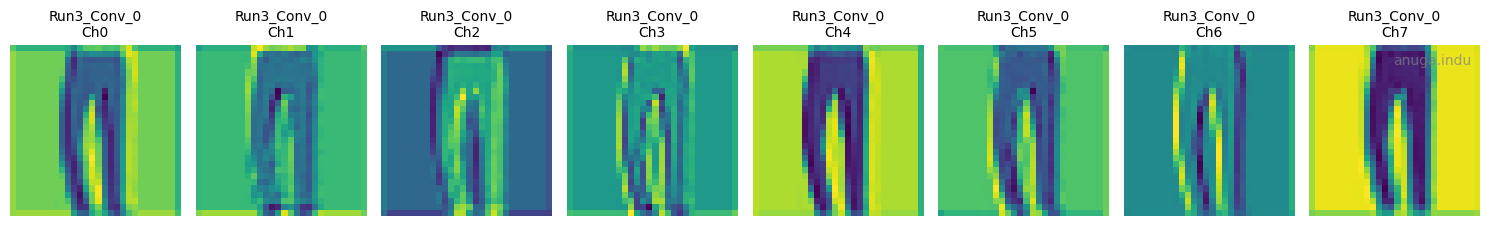

  Conv_1 - Shape: torch.Size([1, 64, 14, 14])


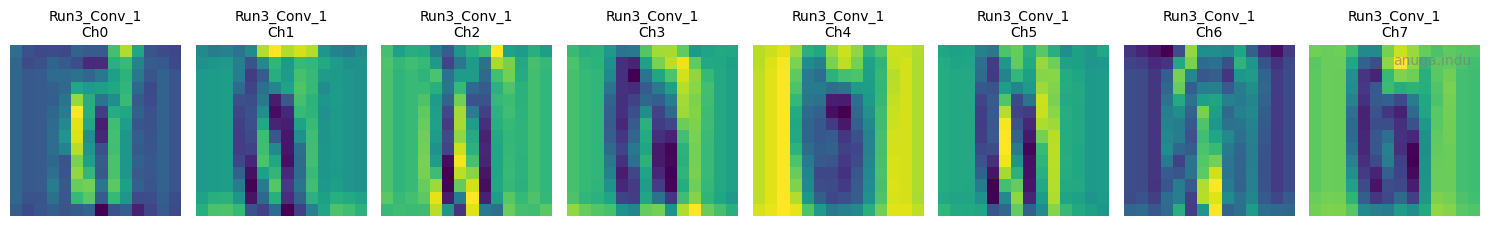

epoch,▁▂▃▃▄▅▆▆▇█
test/accuracy,▁
test/mae,▁
test/rmse,▁
train/ce_loss,█▄▃▂▂▂▁▁▁▁
train/loss,█▃▃▂▂▂▁▁▁▁
train/mse_loss,█▂▂▁▁▁▁▁▁▁
val/accuracy,▁▄▆▆▆▇▇▇██
val/ce_loss,█▅▄▃▃▂▂▂▁▁
val/f1_score,▁▅▆▇▆▇▇▇██
+4,...


Epoch 1/10 | Train Loss: 0.3824 | Val Acc: 0.8000 | Val RMSE: 0.0394
Epoch 2/10 | Train Loss: 0.2763 | Val Acc: 0.8183 | Val RMSE: 0.0342
Epoch 3/10 | Train Loss: 0.2479 | Val Acc: 0.8603 | Val RMSE: 0.0300
Epoch 4/10 | Train Loss: 0.2304 | Val Acc: 0.8782 | Val RMSE: 0.0229
Epoch 5/10 | Train Loss: 0.2196 | Val Acc: 0.8742 | Val RMSE: 0.0307
Epoch 6/10 | Train Loss: 0.2099 | Val Acc: 0.8853 | Val RMSE: 0.0292
Epoch 7/10 | Train Loss: 0.2037 | Val Acc: 0.8905 | Val RMSE: 0.0175
Epoch 8/10 | Train Loss: 0.1991 | Val Acc: 0.8912 | Val RMSE: 0.0276
Epoch 9/10 | Train Loss: 0.1920 | Val Acc: 0.8935 | Val RMSE: 0.0201
Epoch 10/10 | Train Loss: 0.1880 | Val Acc: 0.8903 | Val RMSE: 0.0190


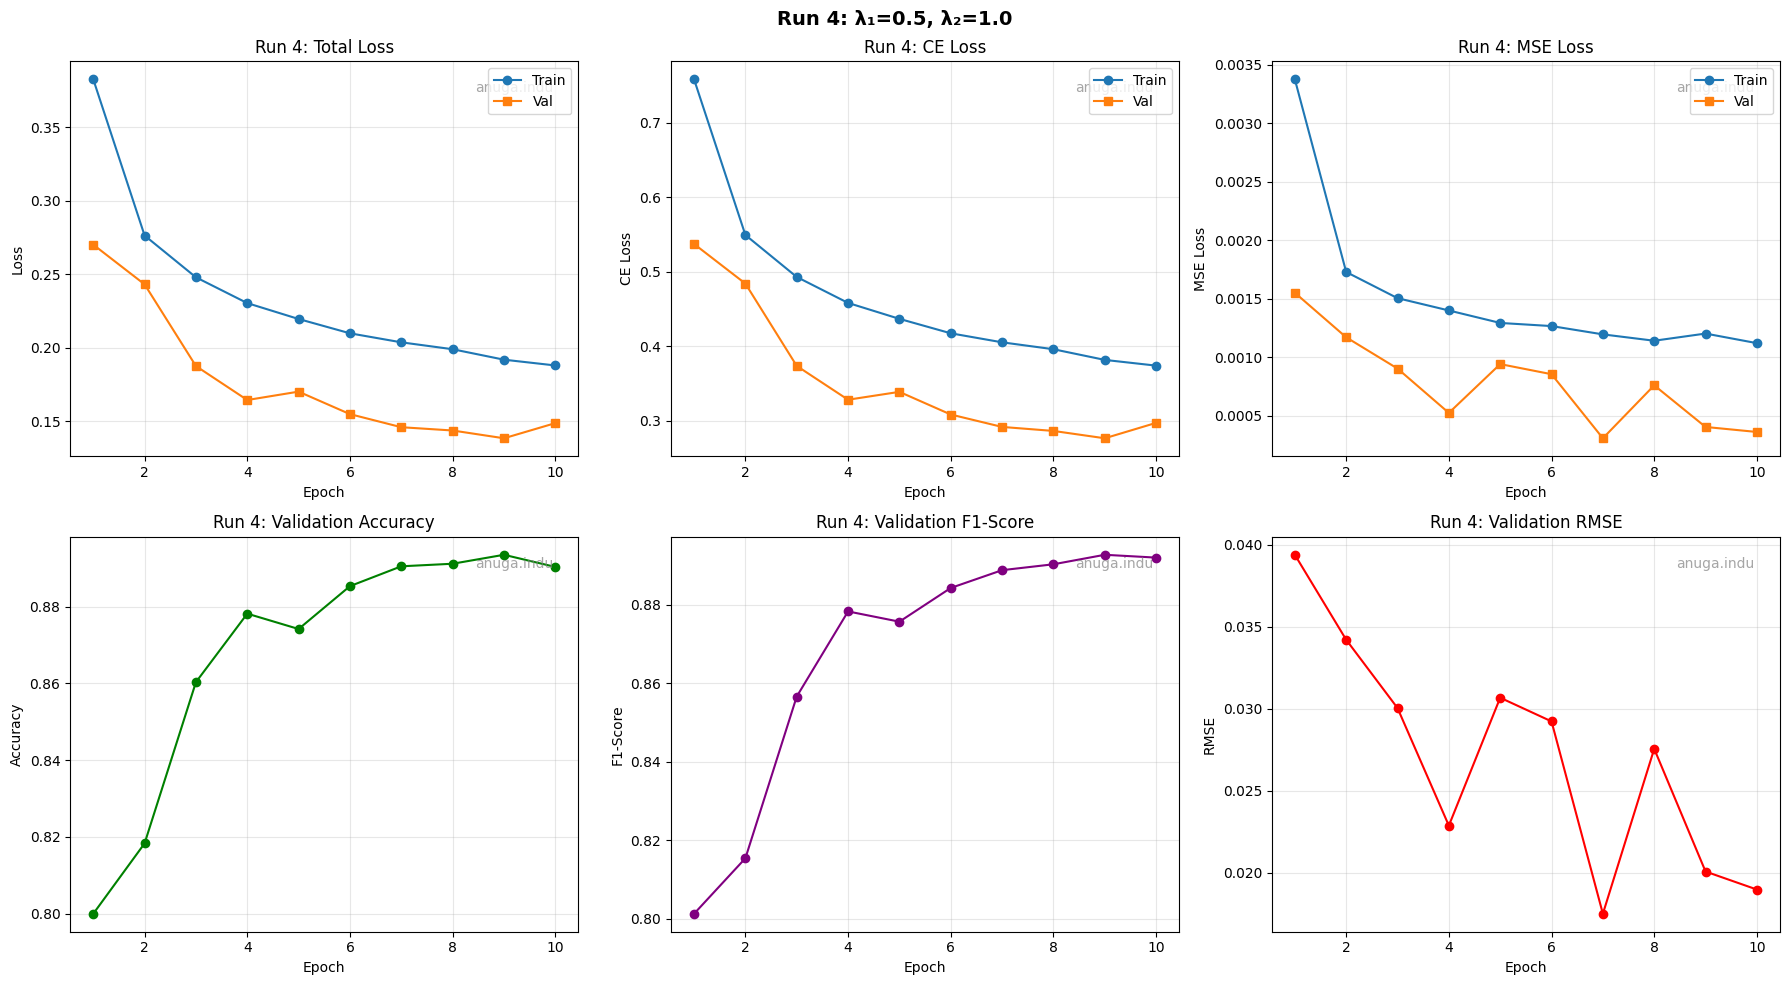

Run 4 Test | Acc: 0.8821 | MAE: 0.0148 | RMSE: 0.0188

FEATURE MAPS FOR RUN 4

Run 4 - Test Image 1
True: Ankle boot | Pred: Ankle boot
True Ink: 0.1673 | Pred Ink: 0.1867


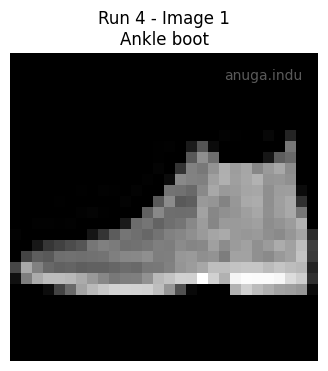

  Conv_0 - Shape: torch.Size([1, 64, 28, 28])


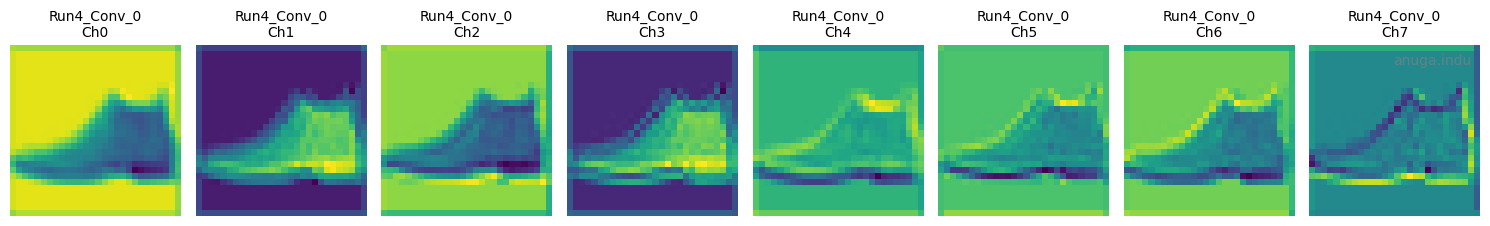

  Conv_1 - Shape: torch.Size([1, 128, 14, 14])


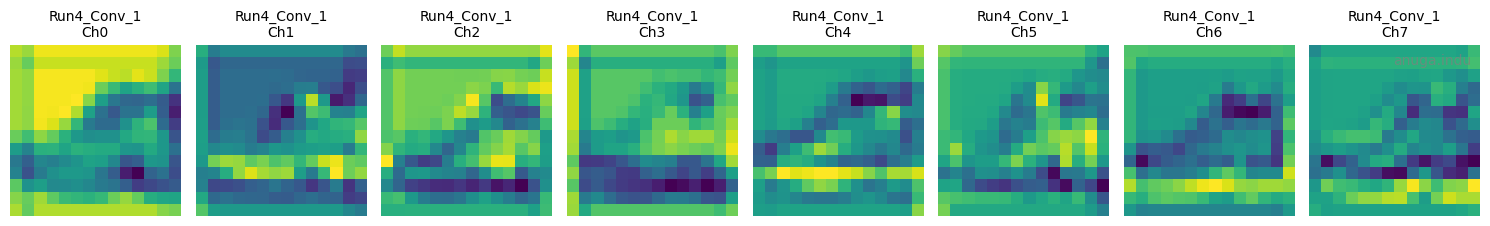

  Conv_2 - Shape: torch.Size([1, 256, 7, 7])


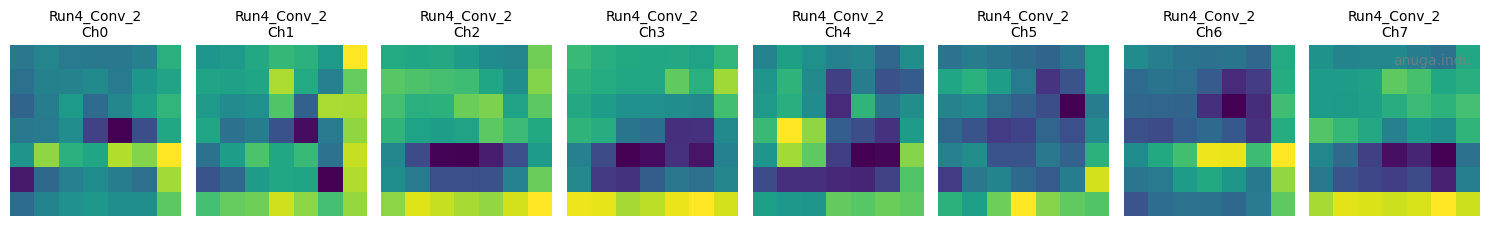


Run 4 - Test Image 2
True: Pullover | Pred: Pullover
True Ink: 0.5052 | Pred Ink: 0.4820


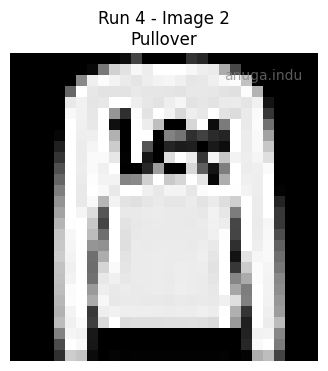

  Conv_0 - Shape: torch.Size([1, 64, 28, 28])


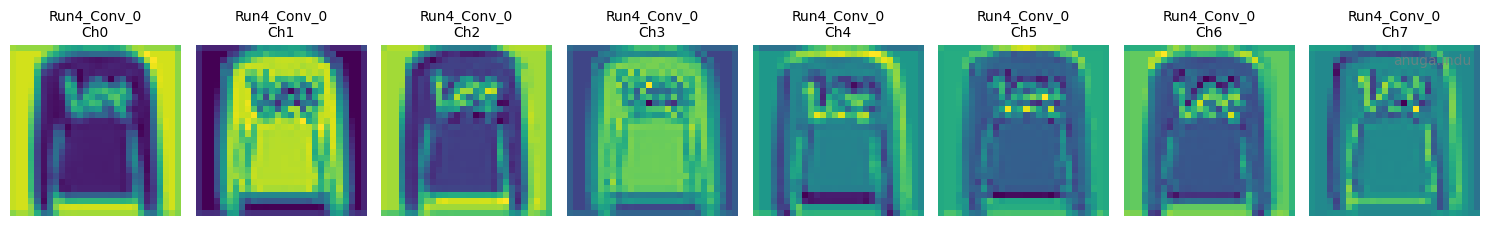

  Conv_1 - Shape: torch.Size([1, 128, 14, 14])


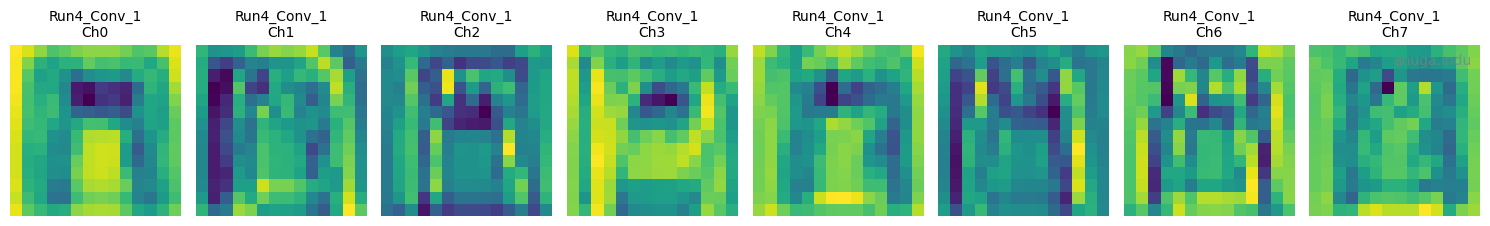

  Conv_2 - Shape: torch.Size([1, 256, 7, 7])


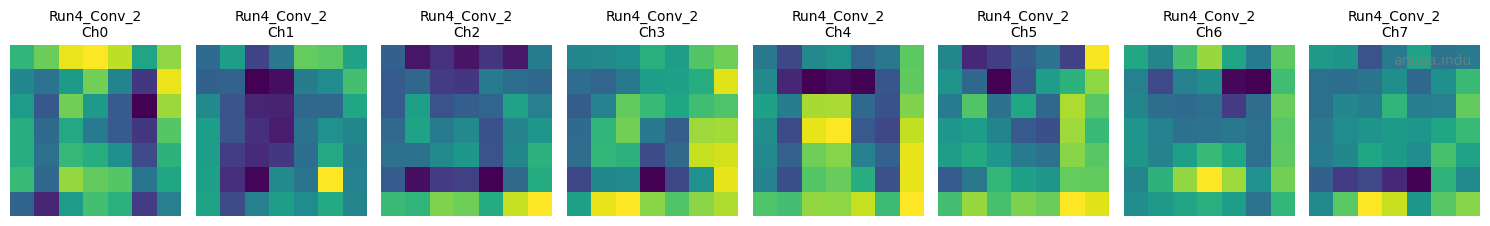


Run 4 - Test Image 3
True: Trouser | Pred: Trouser
True Ink: 0.2577 | Pred Ink: 0.2404


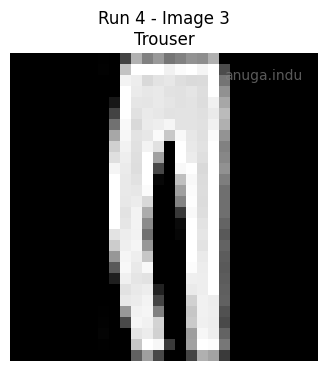

  Conv_0 - Shape: torch.Size([1, 64, 28, 28])


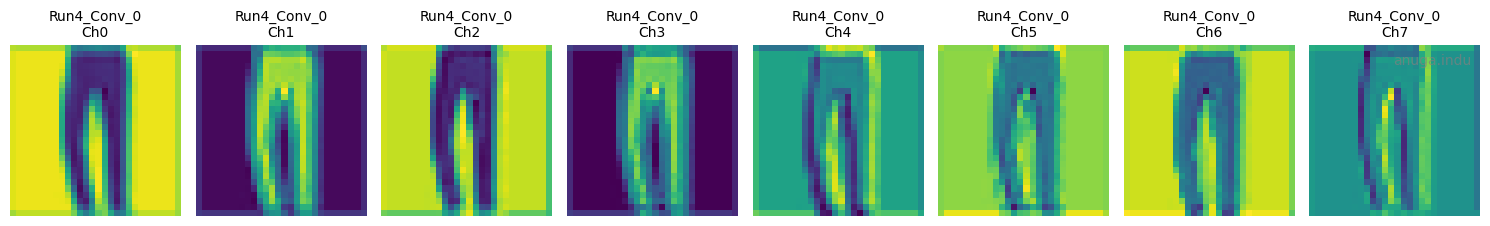

  Conv_1 - Shape: torch.Size([1, 128, 14, 14])


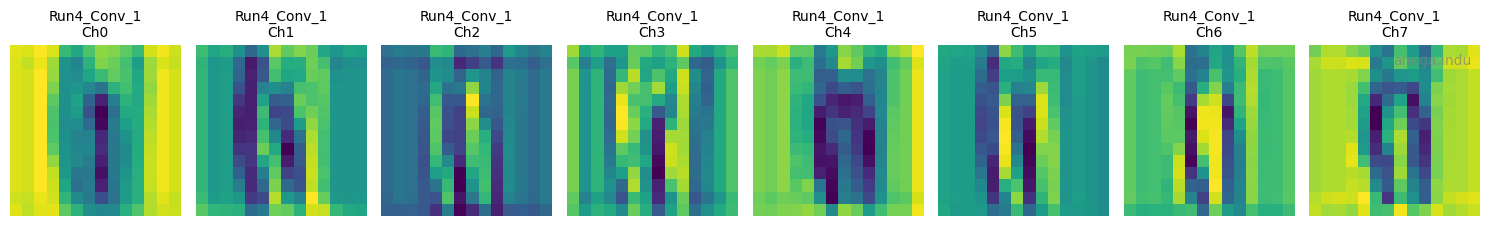

  Conv_2 - Shape: torch.Size([1, 256, 7, 7])


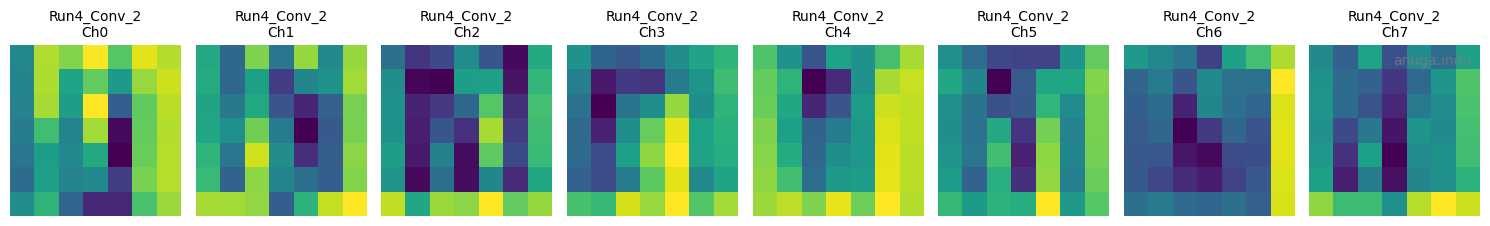

epoch,▁▂▃▃▄▅▆▆▇█
test/accuracy,▁
test/mae,▁
test/rmse,▁
train/ce_loss,█▄▃▃▂▂▂▁▁▁
train/loss,█▄▃▃▂▂▂▁▁▁
train/mse_loss,█▃▂▂▂▁▁▁▁▁
val/accuracy,▁▂▆▇▇▇████
val/ce_loss,█▇▄▂▃▂▁▁▁▂
val/f1_score,▁▂▅▇▇▇████
+4,...


Epoch 1/10 | Train Loss: 0.7309 | Val Acc: 0.8338 | Val RMSE: 0.0419
Epoch 2/10 | Train Loss: 0.5632 | Val Acc: 0.8627 | Val RMSE: 0.0379
Epoch 3/10 | Train Loss: 0.5135 | Val Acc: 0.8595 | Val RMSE: 0.0205
Epoch 4/10 | Train Loss: 0.4832 | Val Acc: 0.8808 | Val RMSE: 0.0235
Epoch 5/10 | Train Loss: 0.4578 | Val Acc: 0.8843 | Val RMSE: 0.0435
Epoch 6/10 | Train Loss: 0.4474 | Val Acc: 0.8925 | Val RMSE: 0.0287
Epoch 7/10 | Train Loss: 0.4355 | Val Acc: 0.8935 | Val RMSE: 0.0336
Epoch 8/10 | Train Loss: 0.4236 | Val Acc: 0.8973 | Val RMSE: 0.0276
Epoch 9/10 | Train Loss: 0.4168 | Val Acc: 0.8998 | Val RMSE: 0.0417
Epoch 10/10 | Train Loss: 0.4145 | Val Acc: 0.8993 | Val RMSE: 0.0399


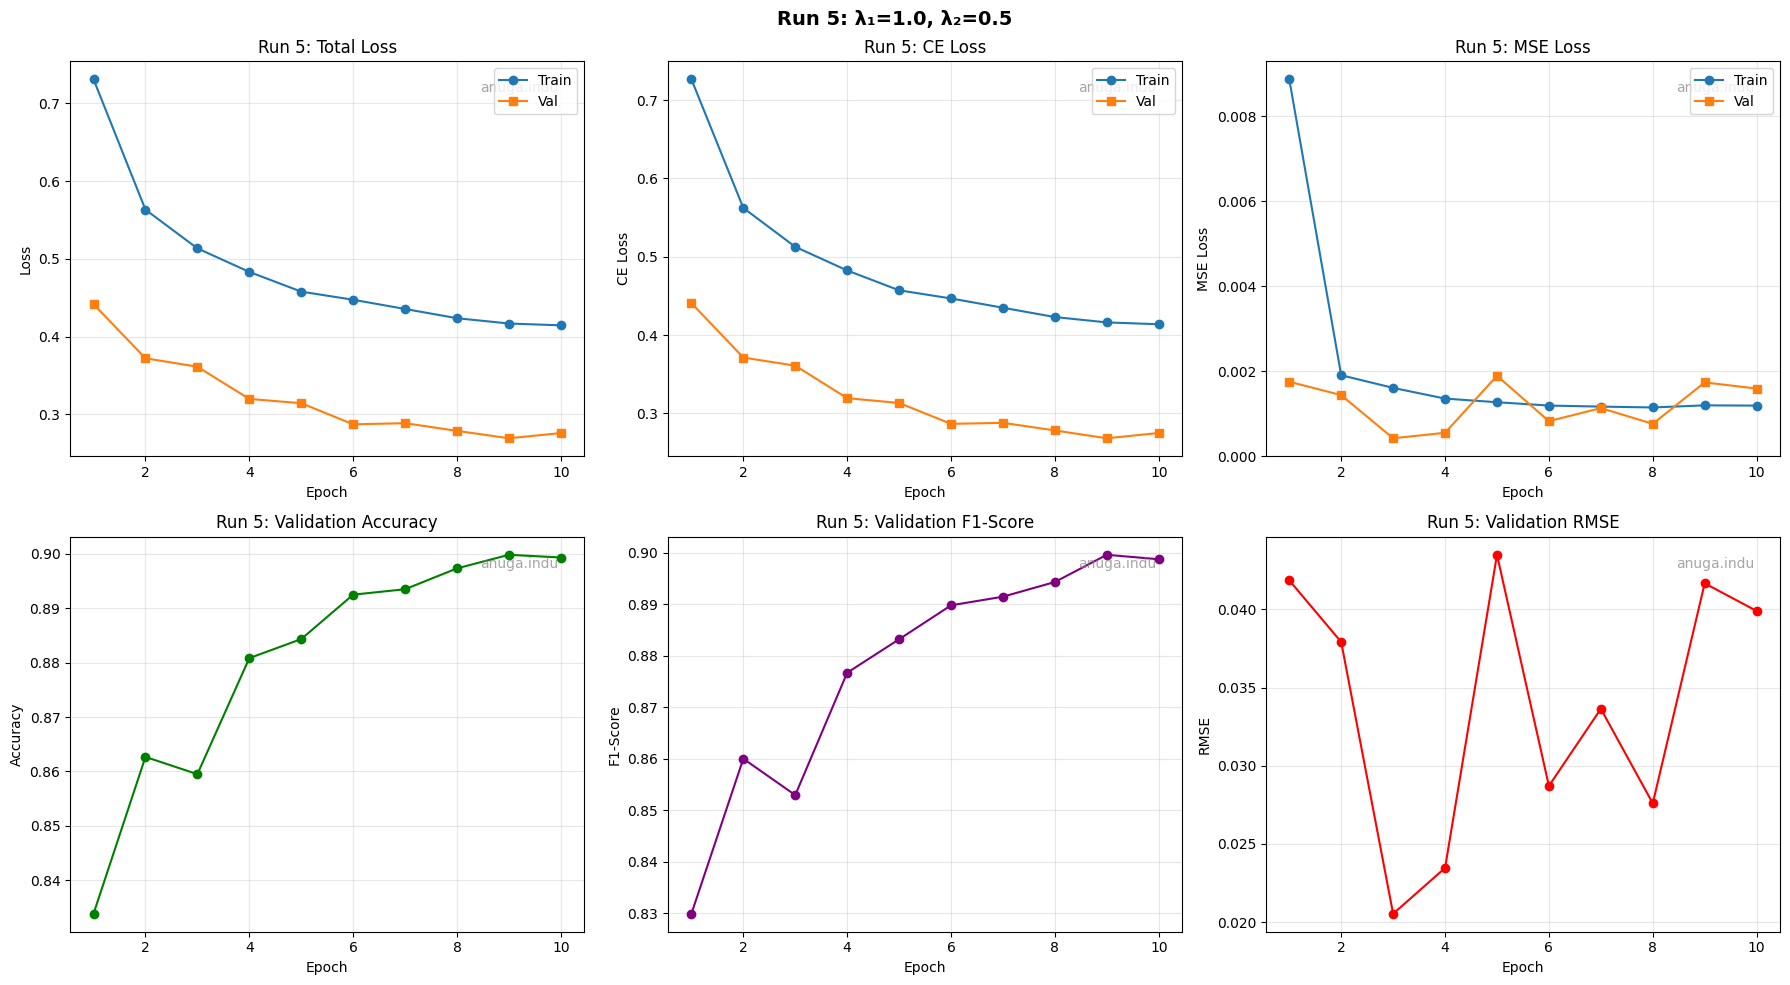

Run 5 Test | Acc: 0.8905 | MAE: 0.0313 | RMSE: 0.0401

FEATURE MAPS FOR RUN 5

Run 5 - Test Image 1
True: Ankle boot | Pred: Ankle boot
True Ink: 0.1673 | Pred Ink: 0.1739


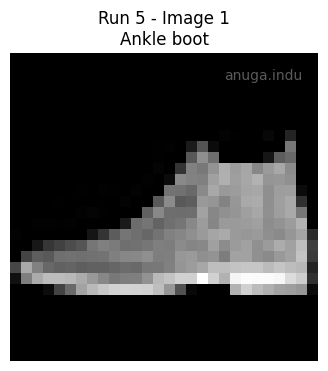

  Conv_0 - Shape: torch.Size([1, 16, 28, 28])


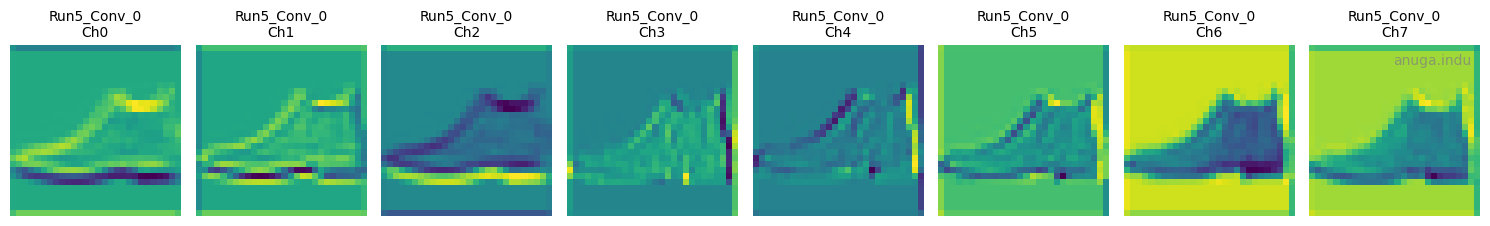

  Conv_1 - Shape: torch.Size([1, 32, 14, 14])


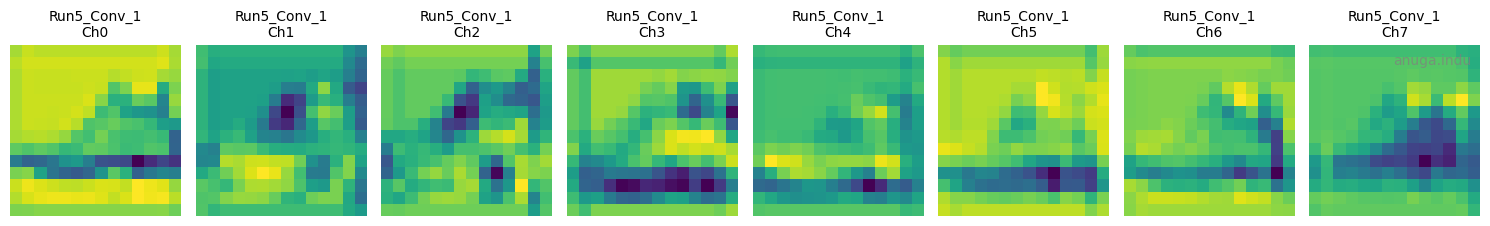


Run 5 - Test Image 2
True: Pullover | Pred: Pullover
True Ink: 0.5052 | Pred Ink: 0.4624


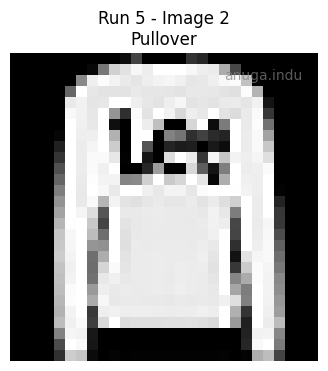

  Conv_0 - Shape: torch.Size([1, 16, 28, 28])


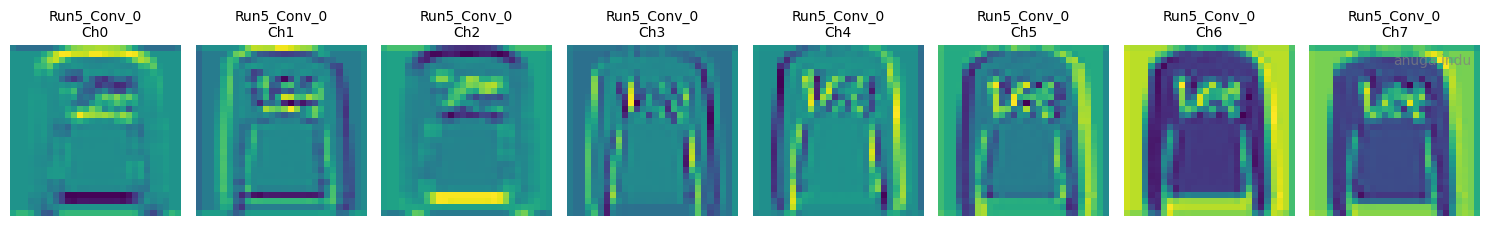

  Conv_1 - Shape: torch.Size([1, 32, 14, 14])


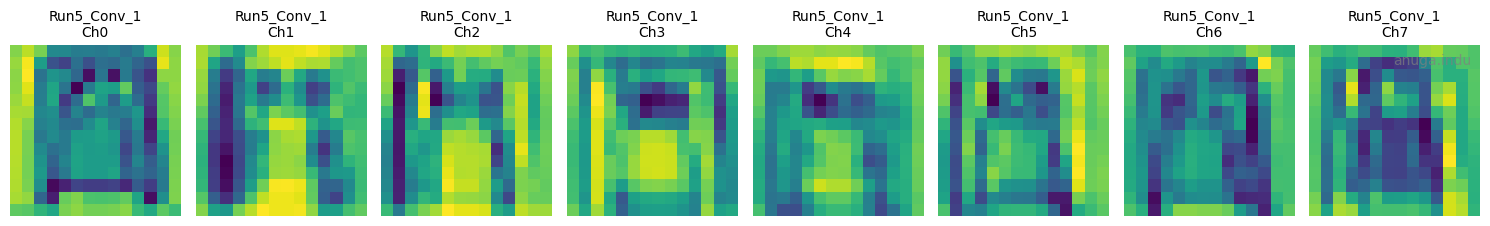


Run 5 - Test Image 3
True: Trouser | Pred: Trouser
True Ink: 0.2577 | Pred Ink: 0.2364


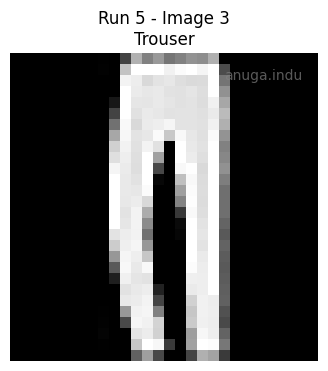

  Conv_0 - Shape: torch.Size([1, 16, 28, 28])


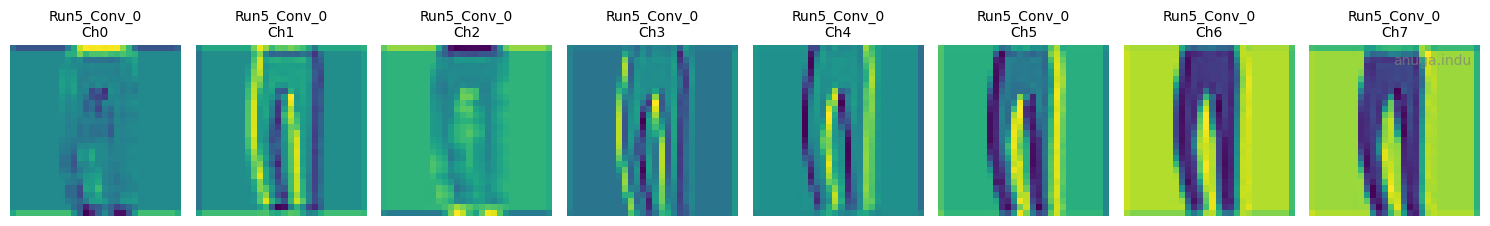

  Conv_1 - Shape: torch.Size([1, 32, 14, 14])


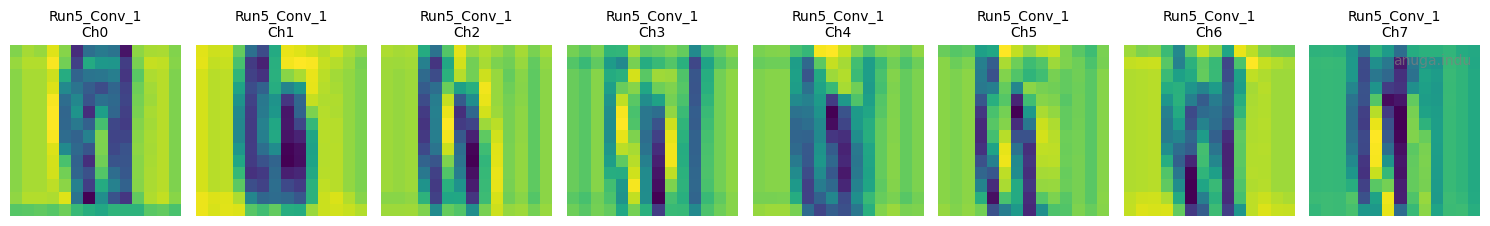

epoch,▁▂▃▃▄▅▆▆▇█
test/accuracy,▁
test/mae,▁
test/rmse,▁
train/ce_loss,█▄▃▃▂▂▁▁▁▁
train/loss,█▄▃▃▂▂▁▁▁▁
train/mse_loss,█▂▁▁▁▁▁▁▁▁
val/accuracy,▁▄▄▆▆▇▇███
val/ce_loss,█▅▅▃▃▂▂▁▁▁
val/f1_score,▁▄▃▆▆▇▇▇██
+4,...


Epoch 1/10 | Train Loss: 0.8196 | Val Acc: 0.8160 | Val RMSE: 0.0519
Epoch 2/10 | Train Loss: 0.6024 | Val Acc: 0.8478 | Val RMSE: 0.0405
Epoch 3/10 | Train Loss: 0.5452 | Val Acc: 0.8585 | Val RMSE: 0.0442
Epoch 4/10 | Train Loss: 0.5145 | Val Acc: 0.8555 | Val RMSE: 0.0439
Epoch 5/10 | Train Loss: 0.4901 | Val Acc: 0.8682 | Val RMSE: 0.0450
Epoch 6/10 | Train Loss: 0.4739 | Val Acc: 0.8862 | Val RMSE: 0.0639
Epoch 7/10 | Train Loss: 0.4651 | Val Acc: 0.8830 | Val RMSE: 0.0535
Epoch 8/10 | Train Loss: 0.4519 | Val Acc: 0.8868 | Val RMSE: 0.0504
Epoch 9/10 | Train Loss: 0.4437 | Val Acc: 0.8918 | Val RMSE: 0.0464
Epoch 10/10 | Train Loss: 0.4346 | Val Acc: 0.8725 | Val RMSE: 0.0406


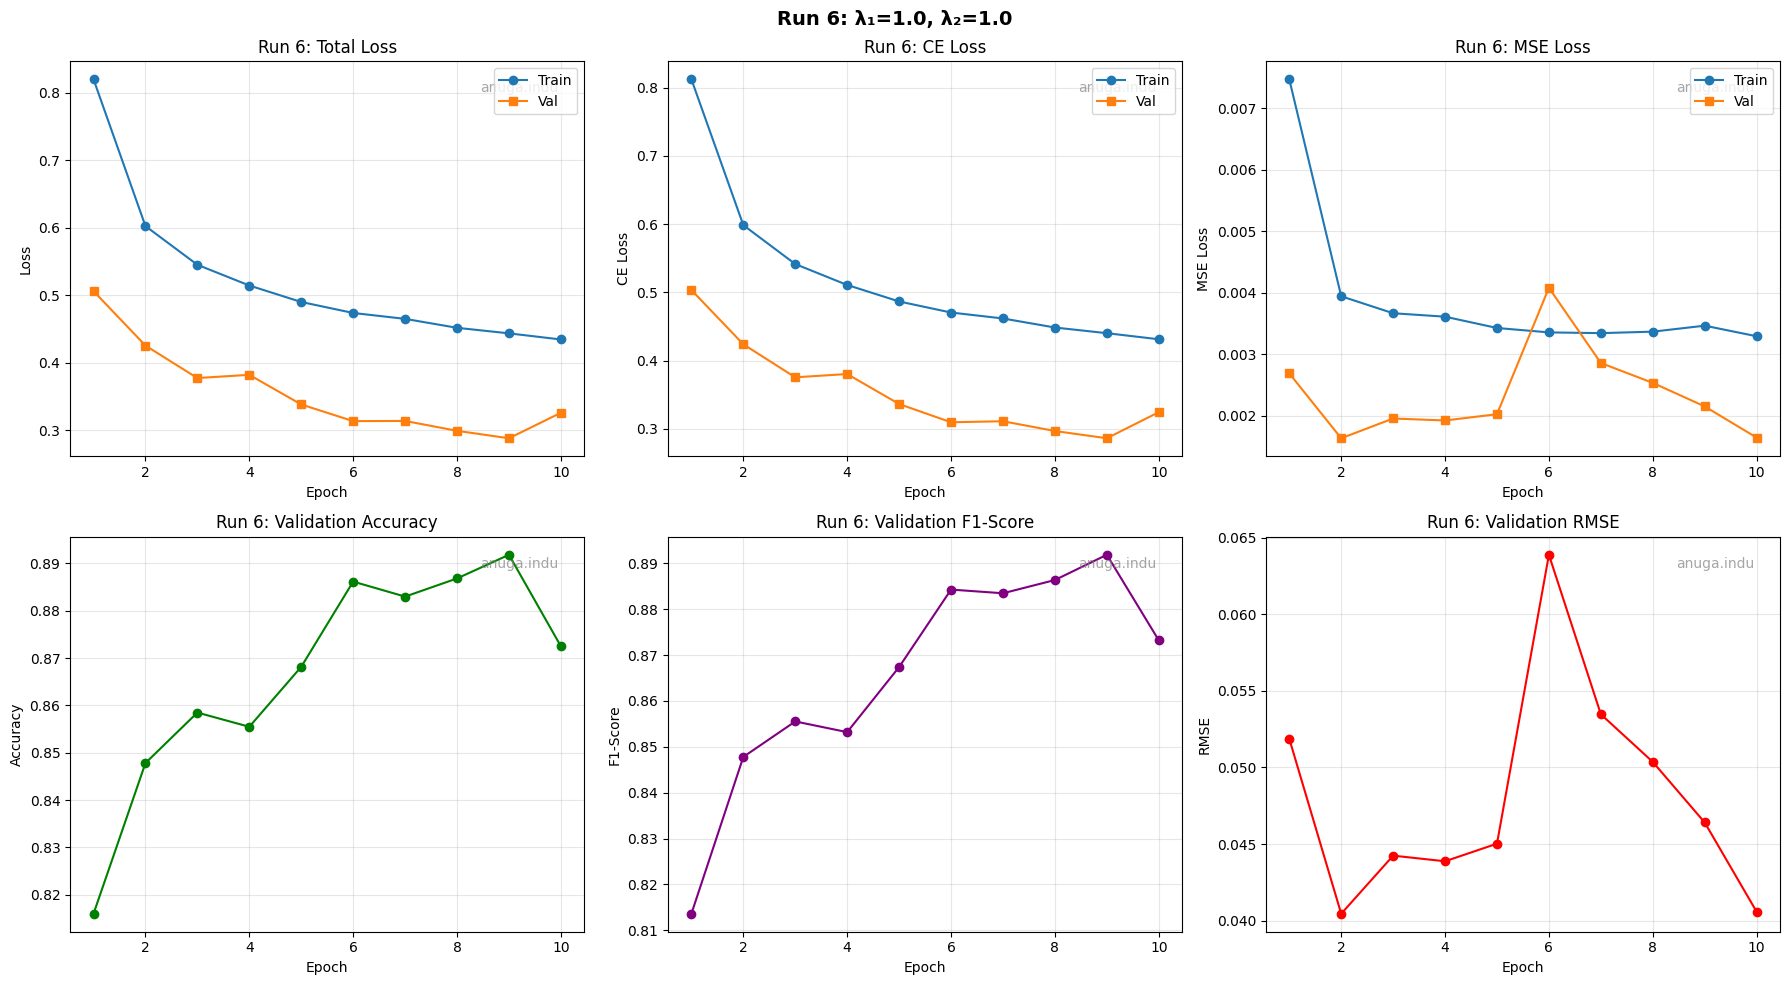

Run 6 Test | Acc: 0.8687 | MAE: 0.0319 | RMSE: 0.0408

FEATURE MAPS FOR RUN 6

Run 6 - Test Image 1
True: Ankle boot | Pred: Ankle boot
True Ink: 0.1673 | Pred Ink: 0.2479


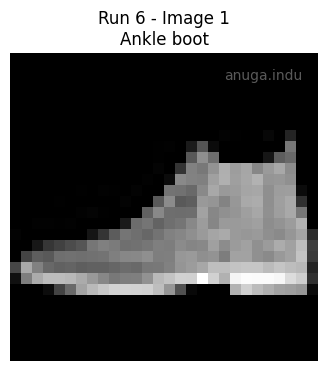

  Conv_0 - Shape: torch.Size([1, 32, 28, 28])


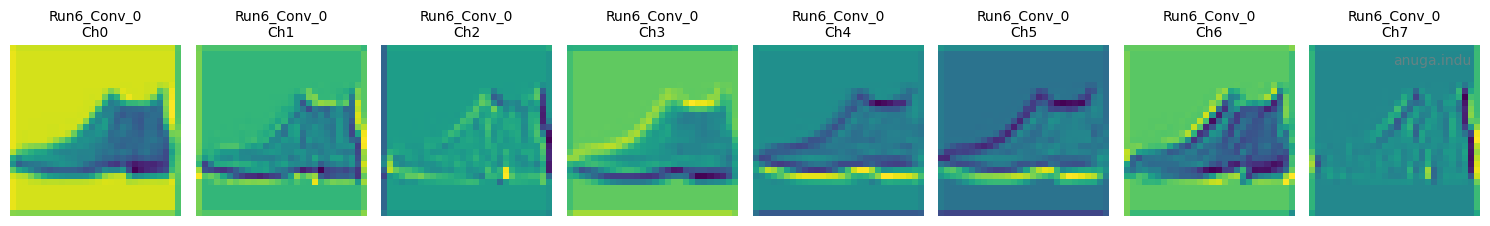

  Conv_1 - Shape: torch.Size([1, 64, 14, 14])


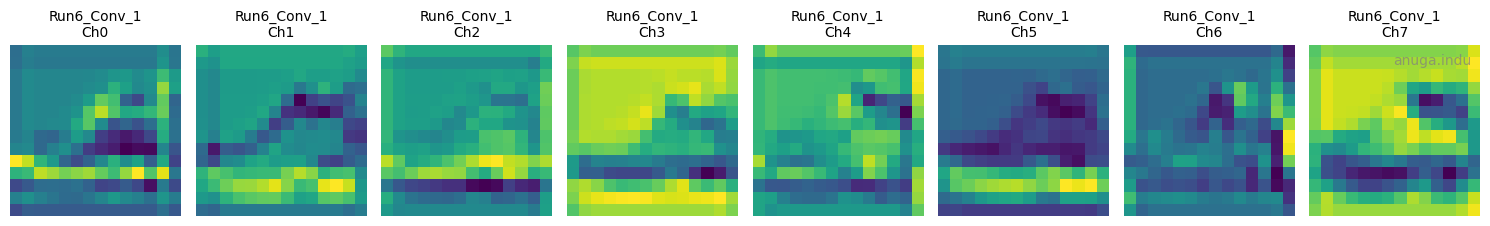

  Conv_2 - Shape: torch.Size([1, 128, 7, 7])


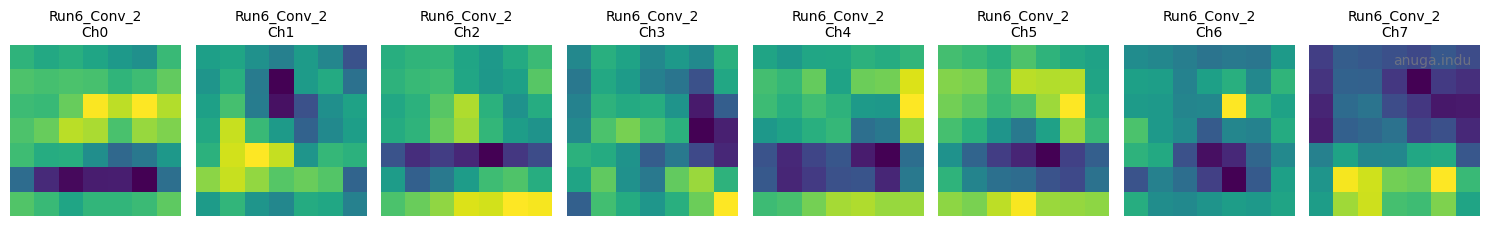

  Conv_3 - Shape: torch.Size([1, 256, 3, 3])


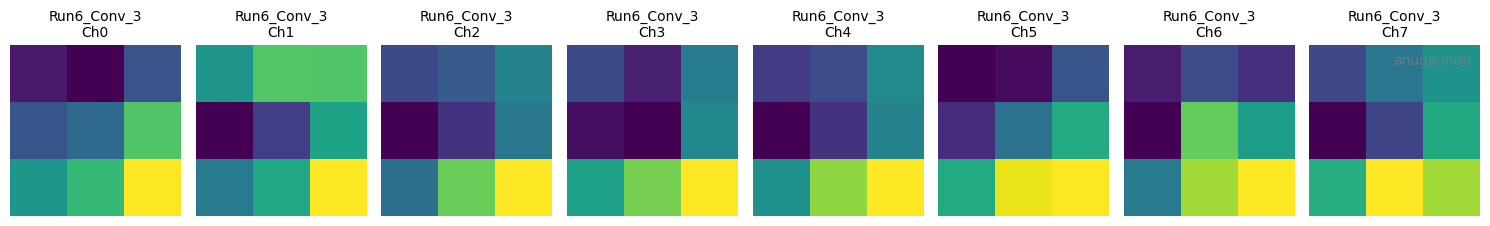


Run 6 - Test Image 2
True: Pullover | Pred: Pullover
True Ink: 0.5052 | Pred Ink: 0.5161


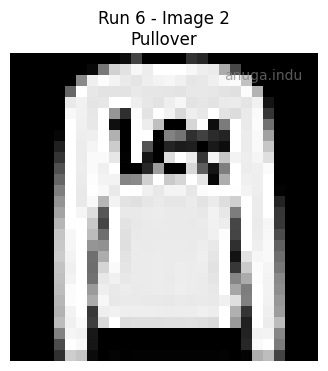

  Conv_0 - Shape: torch.Size([1, 32, 28, 28])


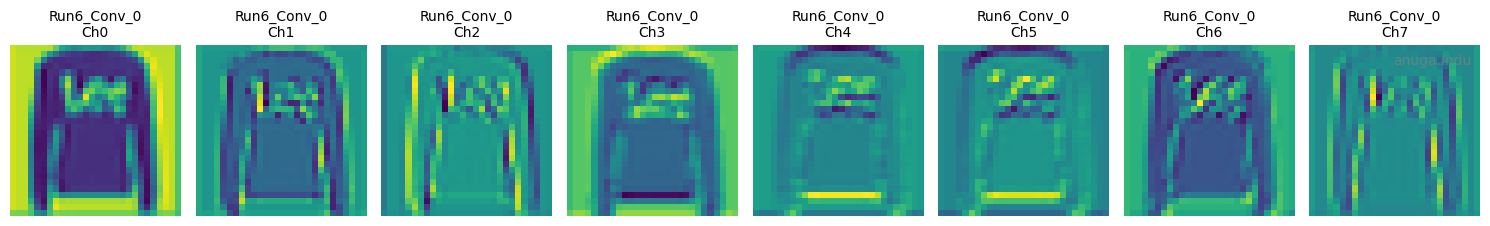

  Conv_1 - Shape: torch.Size([1, 64, 14, 14])


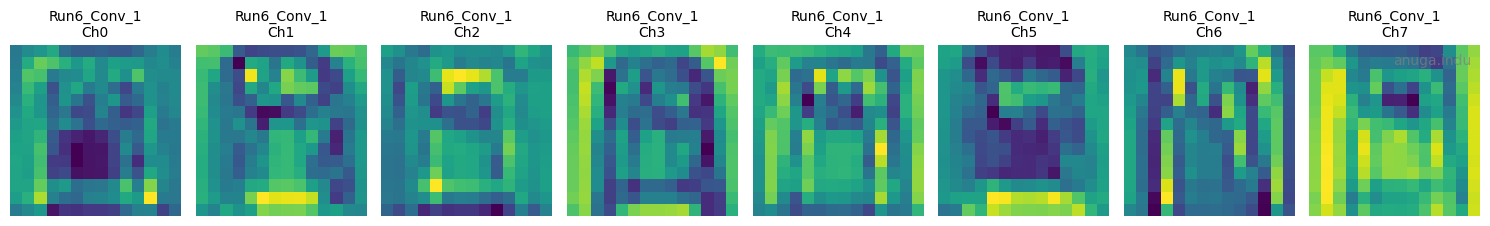

  Conv_2 - Shape: torch.Size([1, 128, 7, 7])


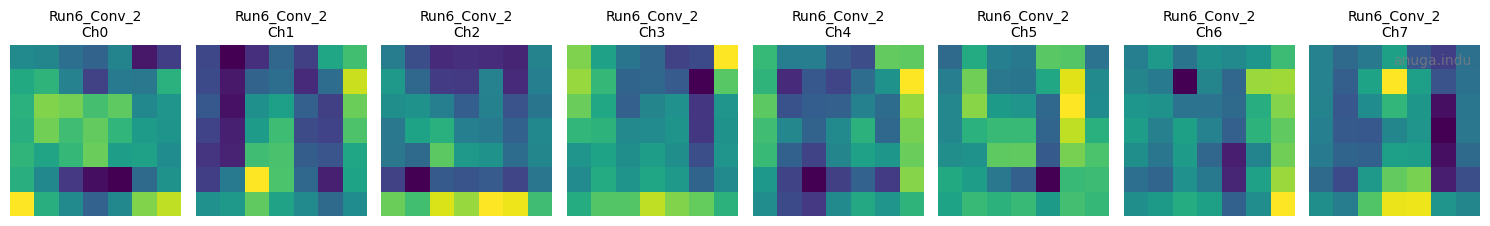

  Conv_3 - Shape: torch.Size([1, 256, 3, 3])


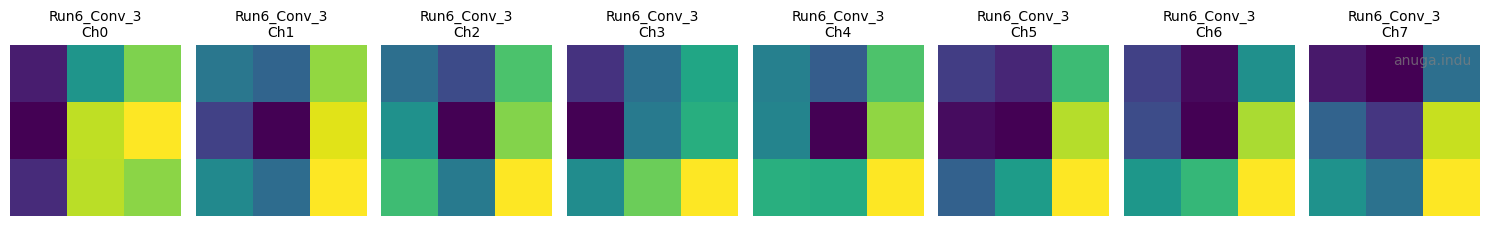


Run 6 - Test Image 3
True: Trouser | Pred: Trouser
True Ink: 0.2577 | Pred Ink: 0.2107


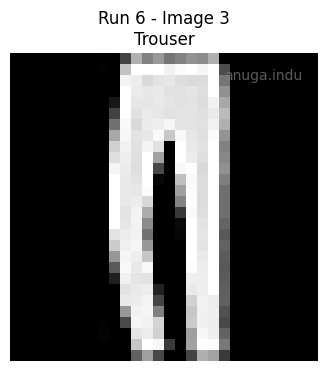

  Conv_0 - Shape: torch.Size([1, 32, 28, 28])


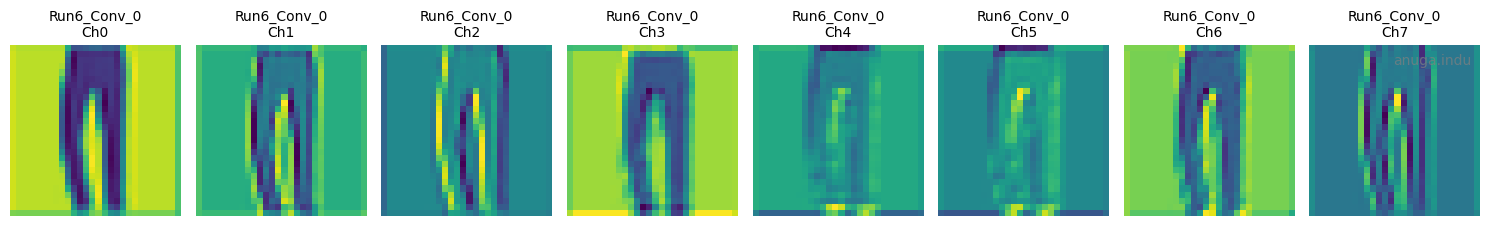

  Conv_1 - Shape: torch.Size([1, 64, 14, 14])


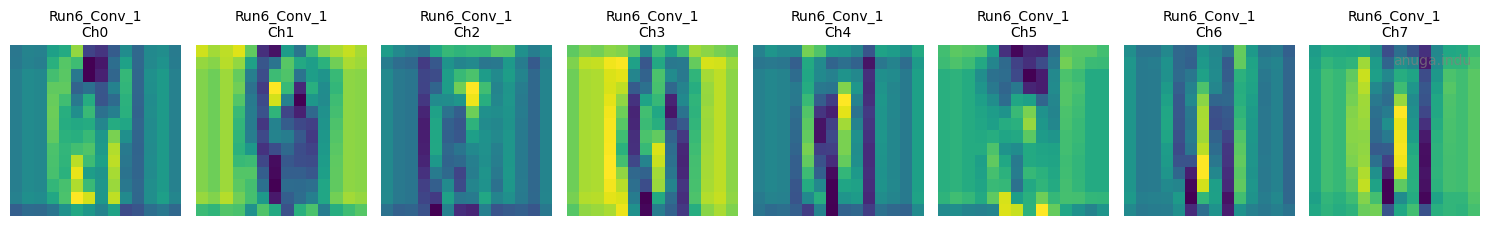

  Conv_2 - Shape: torch.Size([1, 128, 7, 7])


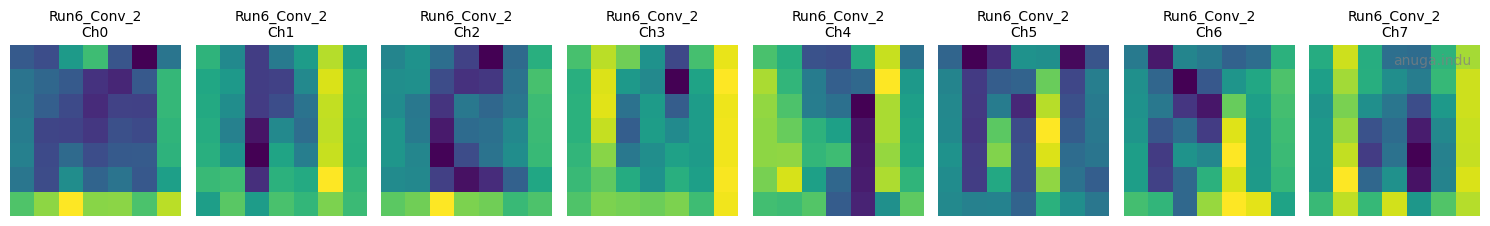

  Conv_3 - Shape: torch.Size([1, 256, 3, 3])


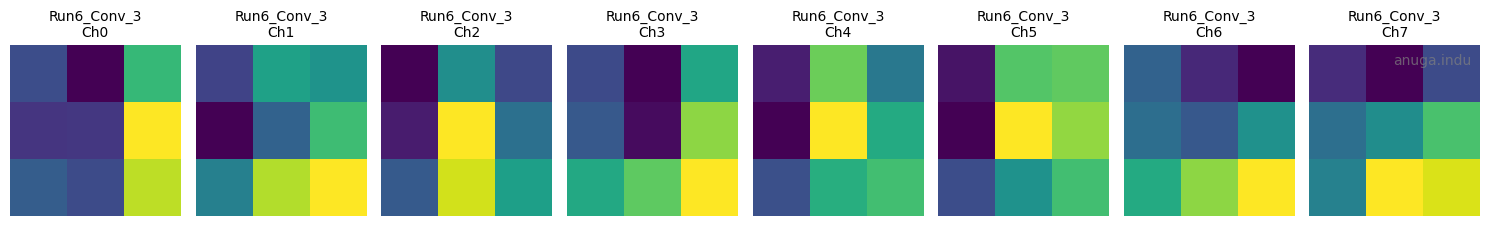

epoch,▁▂▃▃▄▅▆▆▇█
test/accuracy,▁
test/mae,▁
test/rmse,▁
train/ce_loss,█▄▃▂▂▂▂▁▁▁
train/loss,█▄▃▂▂▂▂▁▁▁
train/mse_loss,█▂▂▂▁▁▁▁▁▁
val/accuracy,▁▄▅▅▆▇▇██▆
val/ce_loss,█▅▄▄▃▂▂▁▁▂
val/f1_score,▁▄▅▅▆▇▇██▆
+4,...



Best Accuracy Model: {'lr': 0.001, 'dropout': 0.3, 'optimizer': 'Adam', 'lambda_class': 1.0, 'lambda_reg': 1.0, 'batch_size': 64, 'num_blocks': 3, 'filters': [32, 64, 128]}
Best Accuracy: 0.9017

Best RMSE Model: {'lr': 0.01, 'dropout': 0.3, 'optimizer': 'SGD', 'lambda_class': 0.5, 'lambda_reg': 1.0, 'batch_size': 64, 'num_blocks': 3, 'filters': [64, 128, 256]}
Best RMSE: 0.0175

=== Results Summary ===
 run  lambda_class  lambda_reg  val_acc  val_rmse  test_acc  test_rmse
   1          1.00        1.00    90.17      0.02     89.31       0.03
   2          2.00        1.00    87.58      0.03     86.24       0.05
   3          1.00        2.00    89.40      0.02     88.45       0.02
   4          0.50        1.00    89.35      0.02     88.21       0.02
   5          1.00        0.50    89.98      0.02     89.05       0.04
   6          1.00        1.00    89.18      0.04     86.87       0.04


In [6]:
# =========================
# Training function
# =========================
def train_multi_task(model, train_loader, val_loader, optimizer, epochs, lambda_class, lambda_reg, device):

    history = {"train_loss": [], "train_ce": [], "train_mse": [],
               "val_loss": [], "val_ce": [], "val_mse": [],
               "val_acc": [], "val_f1": [], "val_mae": [], "val_rmse": []} 
    
    for epoch in range(epochs):
        # -----------------
        # Training
        # -----------------
        model.train()
        running_loss = 0.0
        running_ce = 0.0
        running_mse = 0.0
        correct = 0
        total_train = 0 
        
        for images, labels, ink in train_loader:
            images, labels, ink = images.to(device), labels.to(device), ink.to(device)
            optimizer.zero_grad()
            class_out, reg_out = model(images)
            loss, ce_loss, mse_loss = multi_task_loss(class_out, labels, reg_out, ink,
                                                      lambda_class=lambda_class,
                                                      lambda_reg=lambda_reg)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            running_ce += ce_loss.item() * images.size(0)
            running_mse += mse_loss.item() * images.size(0)
            preds = class_out.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total_train += labels.size(0)
        
        train_loss = running_loss / total_train  
        train_ce = running_ce / total_train  
        train_mse = running_mse / total_train  
        train_acc = correct / total_train
        
        # -----------------
        # Validation
        # -----------------
        model.eval()
        val_loss_total = 0.0
        val_ce_total = 0.0
        val_mse_total = 0.0
        correct_val = 0
        total_val = 0 
        y_true_class = []  # For F1-score
        y_pred_class = []  # For F1-score
        y_true_reg = []
        y_pred_reg = []
        
        with torch.no_grad():
            for images, labels, ink in val_loader:
                images, labels, ink = images.to(device), labels.to(device), ink.to(device)
                class_out, reg_out = model(images)
                loss, ce_loss, mse_loss = multi_task_loss(class_out, labels, reg_out, ink,
                                                          lambda_class=lambda_class,
                                                          lambda_reg=lambda_reg)
                
                val_loss_total += loss.item() * images.size(0)
                val_ce_total += ce_loss.item() * images.size(0)
                val_mse_total += mse_loss.item() * images.size(0)
                
                preds_class = class_out.argmax(dim=1)
                correct_val += (preds_class == labels).sum().item()
                total_val += labels.size(0)

                # Collect for F1-score
                y_true_class.extend(labels.cpu().numpy())
                y_pred_class.extend(preds_class.cpu().numpy())
                
                # Collect for regression metrics
                y_true_reg.extend(ink.cpu().numpy())
                y_pred_reg.extend(reg_out.squeeze(1).cpu().numpy())
                
        
        val_loss = val_loss_total / total_val
        val_ce = val_ce_total / total_val
        val_mse = val_mse_total / total_val
        val_acc = correct_val / total_val
        val_f1 = f1_score(y_true_class, y_pred_class, average='weighted')
        val_mae = mean_absolute_error(y_true_reg, y_pred_reg)
        val_rmse = np.sqrt(mean_squared_error(y_true_reg, y_pred_reg))
        
        # Save history
        history["train_loss"].append(train_loss)
        history["train_ce"].append(train_ce)
        history["train_mse"].append(train_mse)
        history["val_loss"].append(val_loss)
        history["val_ce"].append(val_ce)
        history["val_mse"].append(val_mse)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)
        history["val_mae"].append(val_mae)
        history["val_rmse"].append(val_rmse)
        
        # Log to wandb per epoch
        wandb.log({
            "train/loss": train_loss,
            "train/ce_loss": train_ce,
            "train/mse_loss": train_mse,
            "val/loss": val_loss,
            "val/ce_loss": val_ce,
            "val/mse_loss": val_mse,
            "val/accuracy": val_acc,
            "val/f1_score": val_f1,
            "val/mae": val_mae,
            "val/rmse": val_rmse,
            "epoch": epoch
        })
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | Val RMSE: {val_rmse:.4f}")
    
    return history


# ==========================================
# Hyperparameter Configurations (5+ runs)
# ==========================================
hyperparameter_runs = [
    # Run 1:
    {"lr": 0.001, "dropout": 0.3, "optimizer": "Adam", "lambda_class": 1.0, "lambda_reg": 1.0, 
     "batch_size": 64, "num_blocks": 3, "filters": [32, 64, 128]},
    
    # Run 2:
    {"lr": 0.001, "dropout": 0.5, "optimizer": "Adam", "lambda_class": 2.0, "lambda_reg": 1.0, 
     "batch_size": 64, "num_blocks": 3, "filters": [32, 64, 128]},
    
    # Run 3:
    {"lr": 0.0005, "dropout": 0.3, "optimizer": "AdamW", "lambda_class": 1.0, "lambda_reg": 2.0, 
     "batch_size": 128, "num_blocks": 2, "filters": [32, 64]},
    
    # Run 4:
    {"lr": 0.01, "dropout": 0.3, "optimizer": "SGD", "lambda_class": 0.5, "lambda_reg": 1.0, 
     "batch_size": 64, "num_blocks": 3, "filters": [64, 128, 256]},
    
    # Run 5:
    {"lr": 0.001, "dropout": 0.3, "optimizer": "Adam", "lambda_class": 1.0, "lambda_reg": 0.5, 
     "batch_size": 64, "num_blocks": 2, "filters": [16, 32]},
    
    # Run 6:
    {"lr": 0.001, "dropout": 0.4, "optimizer": "Adam", "lambda_class": 1.0, "lambda_reg": 1.0, 
     "batch_size": 64, "num_blocks": 4, "filters": [32, 64, 128, 256]},
]


# =========================
# Feature Map Visualization Function
# =========================
def visualize_feature_maps(feature_maps, title_prefix="Layer"):
    """
    Visualizes feature maps from a convolutional layer.
    
    Args:
        feature_maps: [C, H, W] tensor - feature maps from one image
        title_prefix: str - prefix for subplot titles
    
    Displays the first 8 channels in a horizontal grid.
    """
    feature_maps = feature_maps.cpu().detach()
    num_channels = feature_maps.shape[0]
    n = min(8, num_channels)  # Show max 8 channels
    
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    if n == 1:
        axes = [axes]  # Handle single subplot case
    
    for i in range(n):
        axes[i].imshow(feature_maps[i], cmap='viridis')
        axes[i].axis('off')
        axes[i].set_title(f"{title_prefix}\nCh{i}", fontsize=10)
    
    add_watermark(axes[-1])
    
    plt.tight_layout()
    plt.show()



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc_model = None
best_acc = 0
best_acc_config = None

best_rmse_model = None
best_rmse = float('inf')
best_rmse_config = None

results_summary = []
all_histories = []

# =========================
# Loop through runs
# =========================

for i, config in enumerate(hyperparameter_runs):
    wandb.init(
        project="Multi-Task_CNN_on_Fashion-MNIST",
        name=f"run_{i+1}",
        config=config
    )
    
    # Load DataLoaders with batch size
    train_loader, val_loader, test_loader = load_fashion_data(batch_size=config["batch_size"])
    
    # Initialize model
    model = MultiTaskCNN(
        num_blocks=config["num_blocks"],
        filters=config["filters"],
        dropout_prob=config["dropout"]
    ).to(device)
    
    # Optimizer
    if config["optimizer"] == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    elif config["optimizer"] == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=config["lr"])
    elif config["optimizer"] == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=0.9)
    else:
        raise ValueError("Unknown optimizer")
    
    # Train
    history = train_multi_task(model, train_loader, val_loader, optimizer,
                               epochs=10,
                               lambda_class=config["lambda_class"],
                               lambda_reg=config["lambda_reg"],
                               device=device)
    

    # ====================================
    # PLOT METRICS FOR THIS RUN
    # ====================================
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    epochs_range = range(1, len(history['train_loss']) + 1)
    
    # Total Loss
    axes[0, 0].plot(epochs_range, history['train_loss'], marker='o', label='Train')
    axes[0, 0].plot(epochs_range, history['val_loss'], marker='s', label='Val')
    axes[0, 0].set_title(f'Run {i+1}: Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # CE Loss
    axes[0, 1].plot(epochs_range, history['train_ce'], marker='o', label='Train')
    axes[0, 1].plot(epochs_range, history['val_ce'], marker='s', label='Val')
    axes[0, 1].set_title(f'Run {i+1}: CE Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('CE Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # MSE Loss
    axes[0, 2].plot(epochs_range, history['train_mse'], marker='o', label='Train')
    axes[0, 2].plot(epochs_range, history['val_mse'], marker='s', label='Val')
    axes[0, 2].set_title(f'Run {i+1}: MSE Loss')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('MSE Loss')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1, 0].plot(epochs_range, history['val_acc'], marker='o', color='green')
    axes[1, 0].set_title(f'Run {i+1}: Validation Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].grid(True, alpha=0.3)
    
    # F1-Score
    axes[1, 1].plot(epochs_range, history['val_f1'], marker='o', color='purple')
    axes[1, 1].set_title(f'Run {i+1}: Validation F1-Score')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('F1-Score')
    axes[1, 1].grid(True, alpha=0.3)
    
    # RMSE
    axes[1, 2].plot(epochs_range, history['val_rmse'], marker='o', color='red')
    axes[1, 2].set_title(f'Run {i+1}: Validation RMSE')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('RMSE')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.suptitle(f'Run {i+1}: λ₁={config["lambda_class"]}, λ₂={config["lambda_reg"]}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    for ax in axes.flat:
        add_watermark(ax)
    plt.show()
    
    all_histories.append({
        'run': i+1,
        'config': config,
        'history': history
    })

    # Evaluate on Test set
    model.eval()
    y_true, y_pred_reg, correct = [], [], 0
    total = 0
    with torch.no_grad():
        for images, labels, ink in test_loader:
            images, labels, ink = images.to(device), labels.to(device), ink.to(device)
            class_out, reg_out = model(images)
            preds_class = class_out.argmax(dim=1)
            correct += (preds_class == labels).sum().item()
            total += labels.size(0)
            y_true.extend(ink.cpu().numpy())
            y_pred_reg.extend(reg_out.cpu().numpy())
    
    test_acc = correct / total
    test_mae = mean_absolute_error(y_true, y_pred_reg)
    test_rmse = np.sqrt(mean_squared_error(y_true, y_pred_reg))
    
    print(f"Run {i+1} Test | Acc: {test_acc:.4f} | MAE: {test_mae:.4f} | RMSE: {test_rmse:.4f}")


    # ====================================
    # FEATURE MAP VISUALIZATION 
    # ====================================
    print(f"\n{'='*60}")
    print(f"FEATURE MAPS FOR RUN {i+1}")
    print(f"{'='*60}")
    
    # Pick 3 test images
    test_images_run = []
    test_labels_run = []
    test_inks_run = []

    for j, (img_batch, lbl_batch, ink_batch) in enumerate(test_loader):
        # Take the first 3 images from the first batch
        for k in range(min(3, img_batch.size(0))):
            test_images_run.append(img_batch[k:k+1].to(device))  # [1, 1, 28, 28]
            test_labels_run.append(lbl_batch[k].item())          # scalar
            test_inks_run.append(ink_batch[k].item())            # scalar
            if len(test_images_run) >= 3:
                break
        if len(test_images_run) >= 3:
            break
    
    # Register hooks
    feature_maps_dict = {}
    def hook_fn(module, input, output, layer_name):
        feature_maps_dict[layer_name] = output
    
    handles = []
    conv_count = 0
    for layer in model.backbone:
        if isinstance(layer, torch.nn.Conv2d):
            handle = layer.register_forward_hook(
                lambda m, inp, out, idx=conv_count: hook_fn(m, inp, out, f"Conv_{idx}")
            )
            handles.append(handle)
            conv_count += 1
    
    # Visualize for each test image
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    for img_idx, img in enumerate(test_images_run):
        feature_maps_dict = {}
        
        with torch.no_grad():
            class_out, reg_out = model(img)
            pred_class = class_out.argmax(dim=1).item()
            pred_ink = reg_out.item()
        
        print(f"\nRun {i+1} - Test Image {img_idx+1}")
        print(f"True: {class_names[test_labels_run[img_idx]]} | Pred: {class_names[pred_class]}")
        print(f"True Ink: {test_inks_run[img_idx]:.4f} | Pred Ink: {pred_ink:.4f}")
        
        # Display original
        plt.figure(figsize=(4, 4))
        plt.imshow(img[0, 0].cpu(), cmap='gray')
        plt.title(f"Run {i+1} - Image {img_idx+1}\n{class_names[test_labels_run[img_idx]]}")
        plt.axis('off')
        add_watermark() 
        plt.show()
        
        # Visualize feature maps
        for layer_name in sorted(feature_maps_dict.keys()):
            fmap = feature_maps_dict[layer_name]
            print(f"  {layer_name} - Shape: {fmap.shape}")
            visualize_feature_maps(fmap[0], title_prefix=f"Run{i+1}_{layer_name}")
    
    # Remove hooks
    for handle in handles:
        handle.remove()
    


    if max(history["val_acc"]) > best_acc:
        best_acc = max(history["val_acc"])
        best_acc_model = model
        best_acc_config = config
    
    if min(history["val_rmse"]) < best_rmse:
        best_rmse = min(history["val_rmse"])
        best_rmse_model = model
        best_rmse_config = config
    
    results_summary.append({
        'run': i+1,
        'lambda_class': config['lambda_class'],
        'lambda_reg': config['lambda_reg'],
        'val_acc': max(history["val_acc"]),
        'val_rmse': min(history["val_rmse"]),
        'test_acc': test_acc,
        'test_rmse': test_rmse
    })
    
    wandb.log({
        "test/accuracy": test_acc,
        "test/mae": test_mae,
        "test/rmse": test_rmse
    })
    
    wandb.finish()


print(f"\nBest Accuracy Model: {best_acc_config}")
print(f"Best Accuracy: {best_acc:.4f}")

print(f"\nBest RMSE Model: {best_rmse_config}")
print(f"Best RMSE: {best_rmse:.4f}")


# Display the summary
# df_results = pd.DataFrame(results_summary)
# print("\n=== Results Summary ===")
# print(df_results)

df_results = pd.DataFrame(results_summary)
# Convert accuracy columns to percentages for display
df_results_display = df_results.copy()
df_results_display['val_acc'] = df_results_display['val_acc'] * 100
df_results_display['test_acc'] = df_results_display['test_acc'] * 100
print("\n=== Results Summary ===")
print(df_results_display.to_string(index=False, 
                                    float_format=lambda x: f'{x:.2f}'))

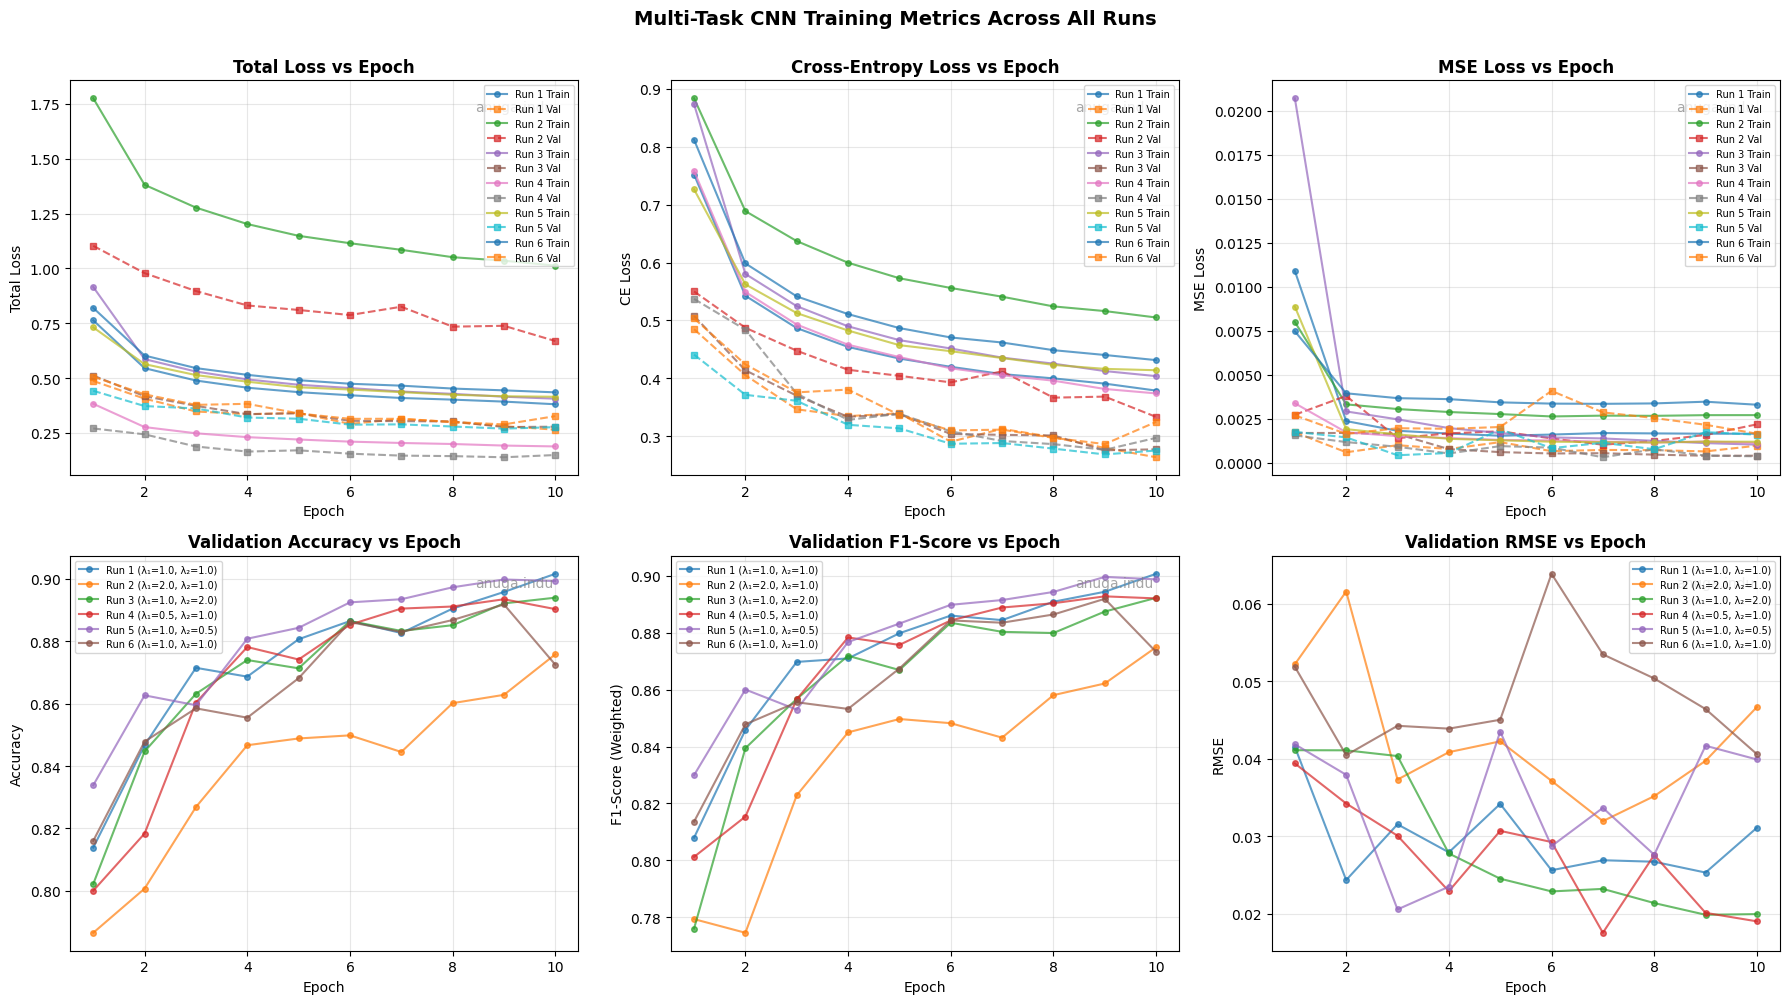

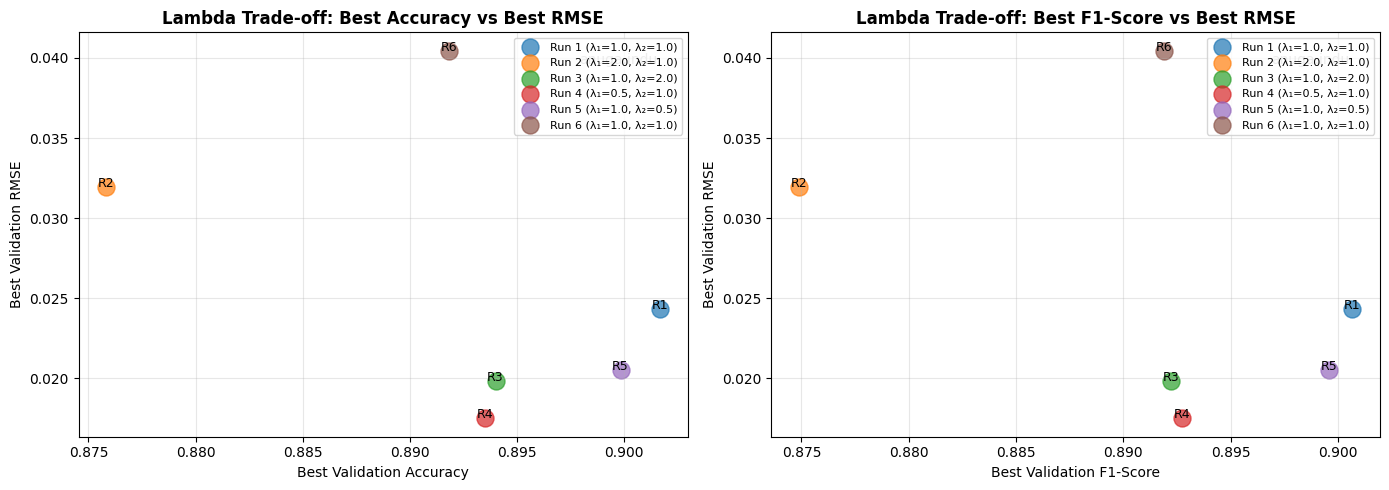


HYPERPARAMETER IMPACT SUMMARY

──────────────────────────────────────────────────────────────────────────────────────────
Run 1: λ_cls=1.0, λ_reg=1.0, lr=0.001, optimizer=Adam, dropout=0.3
──────────────────────────────────────────────────────────────────────────────────────────
  Best Val Accuracy : 0.9017 at epoch 10
  Best Val F1-Score : 0.9007 at epoch 10
  Best Val RMSE     : 0.0243 at epoch 2
  Final Train Loss  : 0.3803
  Final Val Loss    : 0.2644

──────────────────────────────────────────────────────────────────────────────────────────
Run 2: λ_cls=2.0, λ_reg=1.0, lr=0.001, optimizer=Adam, dropout=0.5
──────────────────────────────────────────────────────────────────────────────────────────
  Best Val Accuracy : 0.8758 at epoch 10
  Best Val F1-Score : 0.8749 at epoch 10
  Best Val RMSE     : 0.0319 at epoch 7
  Final Train Loss  : 1.0127
  Final Val Loss    : 0.6686

──────────────────────────────────────────────────────────────────────────────────────────
Run 3: λ_cls=1.0,

In [7]:
# Create a large figure with 6 subplots (2 rows x 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Total Loss (Train & Validation)
axes[0, 0].set_title('Total Loss vs Epoch', fontsize=12, fontweight='bold')
for h in all_histories:
    epochs = range(1, len(h['history']['train_loss']) + 1)
    axes[0, 0].plot(epochs, h['history']['train_loss'], marker='o', markersize=4, 
                     label=f"Run {h['run']} Train", alpha=0.7)
    axes[0, 0].plot(epochs, h['history']['val_loss'], marker='s', markersize=4, 
                     linestyle='--', label=f"Run {h['run']} Val", alpha=0.7)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Total Loss')
axes[0, 0].legend(fontsize=7, loc='best')
axes[0, 0].grid(True, alpha=0.3)

# 2. Cross-Entropy Loss
axes[0, 1].set_title('Cross-Entropy Loss vs Epoch', fontsize=12, fontweight='bold')
for h in all_histories:
    epochs = range(1, len(h['history']['train_ce']) + 1)
    axes[0, 1].plot(epochs, h['history']['train_ce'], marker='o', markersize=4, 
                     label=f"Run {h['run']} Train", alpha=0.7)
    axes[0, 1].plot(epochs, h['history']['val_ce'], marker='s', markersize=4, 
                     linestyle='--', label=f"Run {h['run']} Val", alpha=0.7)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('CE Loss')
axes[0, 1].legend(fontsize=7, loc='best')
axes[0, 1].grid(True, alpha=0.3)

# 3. MSE Loss
axes[0, 2].set_title('MSE Loss vs Epoch', fontsize=12, fontweight='bold')
for h in all_histories:
    epochs = range(1, len(h['history']['train_mse']) + 1)
    axes[0, 2].plot(epochs, h['history']['train_mse'], marker='o', markersize=4, 
                     label=f"Run {h['run']} Train", alpha=0.7)
    axes[0, 2].plot(epochs, h['history']['val_mse'], marker='s', markersize=4, 
                     linestyle='--', label=f"Run {h['run']} Val", alpha=0.7)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('MSE Loss')
axes[0, 2].legend(fontsize=7, loc='best')
axes[0, 2].grid(True, alpha=0.3)

# 4. Validation Accuracy
axes[1, 0].set_title('Validation Accuracy vs Epoch', fontsize=12, fontweight='bold')
for h in all_histories:
    epochs = range(1, len(h['history']['val_acc']) + 1)
    axes[1, 0].plot(epochs, h['history']['val_acc'], marker='o', markersize=4, 
                     label=f"Run {h['run']} (λ₁={h['config']['lambda_class']}, λ₂={h['config']['lambda_reg']})", 
                     alpha=0.7)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend(fontsize=7, loc='best')
axes[1, 0].grid(True, alpha=0.3)

# 5. Validation F1-Score
axes[1, 1].set_title('Validation F1-Score vs Epoch', fontsize=12, fontweight='bold')
for h in all_histories:
    epochs = range(1, len(h['history']['val_f1']) + 1)
    axes[1, 1].plot(epochs, h['history']['val_f1'], marker='o', markersize=4, 
                     label=f"Run {h['run']} (λ₁={h['config']['lambda_class']}, λ₂={h['config']['lambda_reg']})", 
                     alpha=0.7)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('F1-Score (Weighted)')
axes[1, 1].legend(fontsize=7, loc='best')
axes[1, 1].grid(True, alpha=0.3)

# 6. Validation RMSE
axes[1, 2].set_title('Validation RMSE vs Epoch', fontsize=12, fontweight='bold')
for h in all_histories:
    epochs = range(1, len(h['history']['val_rmse']) + 1)
    axes[1, 2].plot(epochs, h['history']['val_rmse'], marker='o', markersize=4, 
                     label=f"Run {h['run']} (λ₁={h['config']['lambda_class']}, λ₂={h['config']['lambda_reg']})", 
                     alpha=0.7)
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('RMSE')
axes[1, 2].legend(fontsize=7, loc='best')
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle('Multi-Task CNN Training Metrics Across All Runs', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
for ax in axes.flat:
    add_watermark(ax)
plt.show()

# =========================
# Additional: Lambda Trade-off Analysis
# =========================

fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))

# Trade-off: Accuracy vs RMSE
axes2[0].set_title('Lambda Trade-off: Best Accuracy vs Best RMSE', fontsize=12, fontweight='bold')
for h in all_histories:
    best_acc = max(h['history']['val_acc'])
    best_rmse = min(h['history']['val_rmse'])
    axes2[0].scatter(best_acc, best_rmse, s=150, alpha=0.7,
                     label=f"Run {h['run']} (λ₁={h['config']['lambda_class']}, λ₂={h['config']['lambda_reg']})")
    axes2[0].annotate(f"R{h['run']}", (best_acc, best_rmse), fontsize=9, ha='center')
axes2[0].set_xlabel('Best Validation Accuracy')
axes2[0].set_ylabel('Best Validation RMSE')
axes2[0].legend(fontsize=8, loc='best')
axes2[0].grid(True, alpha=0.3)

# Trade-off: F1-Score vs RMSE
axes2[1].set_title('Lambda Trade-off: Best F1-Score vs Best RMSE', fontsize=12, fontweight='bold')
for h in all_histories:
    best_f1 = max(h['history']['val_f1'])
    best_rmse = min(h['history']['val_rmse'])
    axes2[1].scatter(best_f1, best_rmse, s=150, alpha=0.7,
                     label=f"Run {h['run']} (λ₁={h['config']['lambda_class']}, λ₂={h['config']['lambda_reg']})")
    axes2[1].annotate(f"R{h['run']}", (best_f1, best_rmse), fontsize=9, ha='center')
axes2[1].set_xlabel('Best Validation F1-Score')
axes2[1].set_ylabel('Best Validation RMSE')
axes2[1].legend(fontsize=8, loc='best')
axes2[1].grid(True, alpha=0.3)

plt.tight_layout()
for ax in axes2:
    add_watermark(ax)
plt.show()

# =========================
# Hyperparameter Impact Summary 
# =========================

print("\n" + "="*90)
print("HYPERPARAMETER IMPACT SUMMARY")
print("="*90)

for h in all_histories:
    config = h['config']
    history = h['history']
    print(f"\n{'─'*90}")
    print(f"Run {h['run']}: λ_cls={config['lambda_class']}, λ_reg={config['lambda_reg']}, "
          f"lr={config['lr']}, optimizer={config['optimizer']}, dropout={config['dropout']}")
    print(f"{'─'*90}")
    print(f"  Best Val Accuracy : {max(history['val_acc']):.4f} at epoch {history['val_acc'].index(max(history['val_acc']))+1}")
    print(f"  Best Val F1-Score : {max(history['val_f1']):.4f} at epoch {history['val_f1'].index(max(history['val_f1']))+1}")
    print(f"  Best Val RMSE     : {min(history['val_rmse']):.4f} at epoch {history['val_rmse'].index(min(history['val_rmse']))+1}")
    print(f"  Final Train Loss  : {history['train_loss'][-1]:.4f}")
    print(f"  Final Val Loss    : {history['val_loss'][-1]:.4f}")

print("\n" + "="*90)